In [1]:
pwd

'/scratch/yl7692'

# 2.Preprocess the Datasets

In [2]:
pip install nibabel

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import glob
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
from ipywidgets.widgets import * 
import ipywidgets as widgets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from tqdm import tqdm

## 1) Visualize the MRI images 

In [11]:
datapath_root = '/scratch/yl7692/training'
SAVE_PATH = '/scratch/yl7692/self-attention_Unet_OR/'

<ipython-input-12-fe635c2ddc74>:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  T1_weighted_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_mprage_pp.nii').get_data()
<ipython-input-12-fe635c2ddc74>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  T2_weighted_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_t2_pp.nii').get_data()
<ipython-input-12-fe635c2ddc74>:3: DeprecationWarning: get_data() is deprecated in f

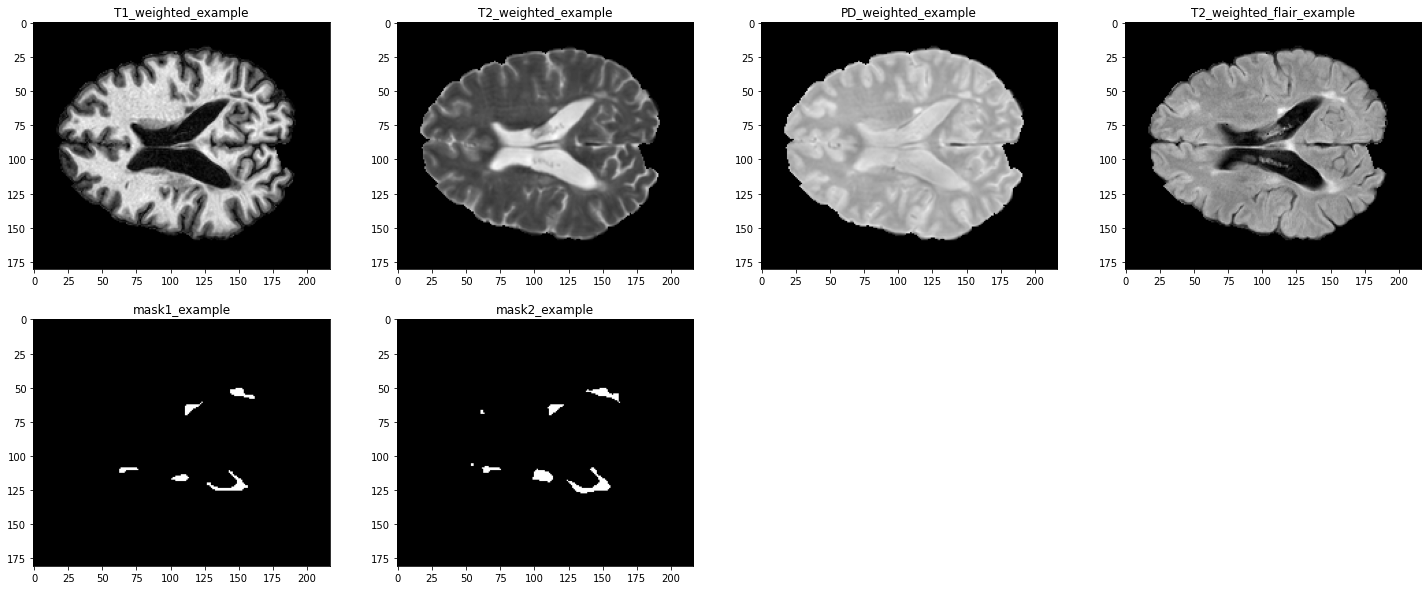

In [12]:
T1_weighted_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_mprage_pp.nii').get_data()
T2_weighted_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_t2_pp.nii').get_data()
PD_weighted_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_pd_pp.nii').get_data()
T2_weighted_flair_example = nib.load(datapath_root + '/training01/preprocessed/training01_01_flair_pp.nii').get_data()
mask1_example = nib.load(datapath_root + '/training01/masks/training01_01_mask1.nii').get_data()
mask2_example = nib.load(datapath_root + '/training01/masks/training01_01_mask2.nii').get_data()
plt.figure(figsize=(25,10))
plt.subplot(2,4,1)
plt.imshow(T1_weighted_example[:,:,90],'gray')
plt.title('T1_weighted_example')
plt.subplot(2,4,2)
plt.imshow(T2_weighted_example[:,:,90],'gray')
plt.title('T2_weighted_example')
plt.subplot(2,4,3)
plt.imshow(PD_weighted_example[:,:,90],'gray')
plt.title('PD_weighted_example')
plt.subplot(2,4,4)
plt.imshow(T2_weighted_flair_example[:,:,90],'gray')
plt.title('T2_weighted_flair_example')
plt.subplot(2,4,5)
plt.imshow(mask1_example[:,:,90],'gray')
plt.title('mask1_example')
plt.subplot(2,4,6)
plt.imshow(mask2_example[:,:,90],'gray')
plt.title('mask2_example')

plt.pause(3)

In [5]:
# ipywidgets for some interactive plots

# slide through dicom images using a slide bar 
def dicom_animation(x):
    plt.figure(figsize=(20,10))
    plt.imshow(T1_weighted_example[:,:,x],'gray')
    return x
interact(dicom_animation, x=(0, len(T1_weighted_example)-1))

NameError: name 'T1_weighted_example' is not defined

## 2) Define function to process 2 raters' groundtruth  

In [5]:
def weight_ground_truth(mask1_path, mask2_path):
    mask1=nib.load(mask1_path).get_data()
    mask2=nib.load(mask2_path).get_data()
    if mask1.shape==mask2.shape:
        fig_shape = mask1.shape 
    else:
        print('Number inconformity for mask, double check path!')
  
    n=fig_shape[2]

    mask_and_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
    mask_or_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
    mask_rnd_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)

    for i in range(n):
        mask_and_weight[:,:,i] = mask1[:,:,i] & mask2[:,:,i]
        mask_or_weight[:,:,i] = mask1[:,:,i] | mask2[:,:,i]
        mask_rnd_weight = (mask_or_weight - mask_and_weight)*np.random.randint(0,2,(fig_shape[0],fig_shape[1],n)) + mask_and_weight


    return mask_and_weight, mask_or_weight, mask_rnd_weight


<ipython-input-7-f3023dfad3f4>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask1=nib.load(mask1_path).get_data()
<ipython-input-7-f3023dfad3f4>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask2=nib.load(mask2_path).get_data()


Text(0.5, 1.0, 'mask_rnd_weight')

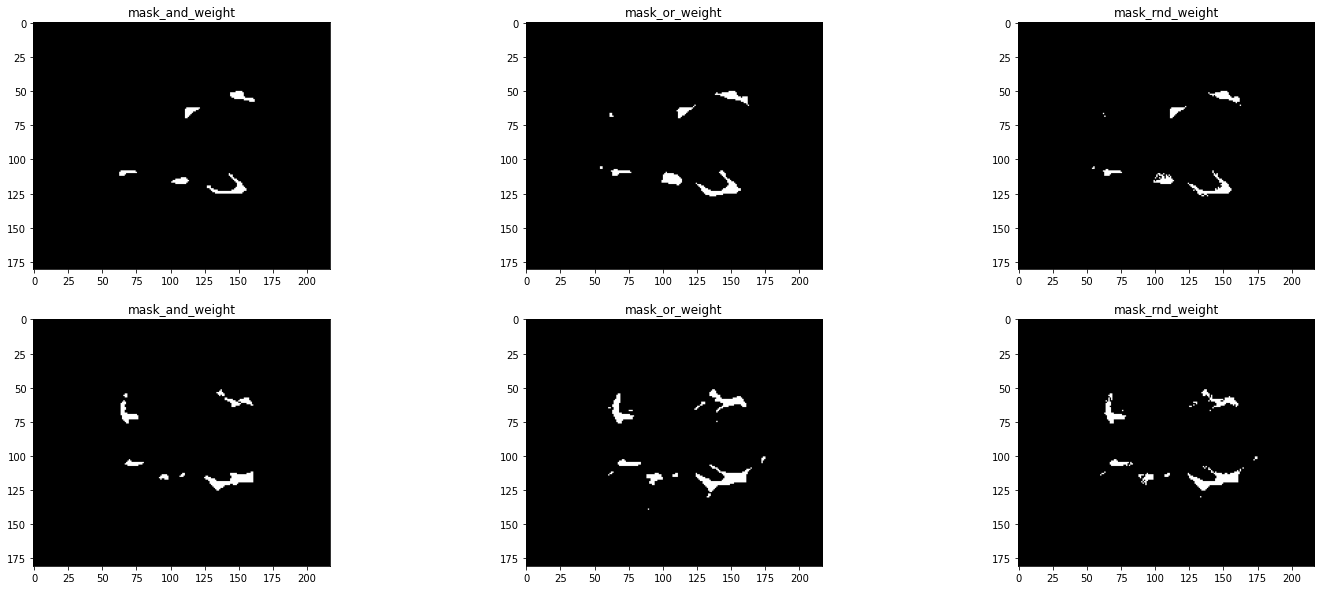

In [8]:
#mask_or_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
#mask_and_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
mask1_path = os.path.join(datapath_root,'training01/masks/training01_01_mask1.nii')
mask2_path = os.path.join(datapath_root,'training01/masks/training01_01_mask2.nii')
mask3_path = os.path.join(datapath_root,'training02/masks/training02_02_mask1.nii')
mask4_path = os.path.join(datapath_root,'training02/masks/training02_02_mask2.nii')

mask_and_weight, mask_or_weight, mask_rnd_weight = weight_ground_truth(mask1_path, mask2_path)
mask_and_weight2, mask_or_weight2, mask_rnd_weight2 = weight_ground_truth(mask3_path, mask4_path)

plt.figure(figsize=(25,10))
plt.subplot(2,3,1)
plt.imshow(mask_and_weight[:,:,90],'gray')
plt.title('mask_and_weight')
plt.subplot(2,3,2)
plt.imshow(mask_or_weight[:,:,90],'gray')
plt.title('mask_or_weight')
plt.subplot(2,3,3)
plt.imshow(mask_rnd_weight[:,:,90],'gray')
plt.title('mask_rnd_weight')
plt.subplot(2,3,4)
plt.imshow(mask_and_weight2[:,:,90],'gray')
plt.title('mask_and_weight')
plt.subplot(2,3,5)
plt.imshow(mask_or_weight2[:,:,90],'gray')
plt.title('mask_or_weight')
plt.subplot(2,3,6)
plt.imshow(mask_rnd_weight2[:,:,90],'gray')
plt.title('mask_rnd_weight')

<ipython-input-7-f3023dfad3f4>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask1=nib.load(mask1_path).get_data()
<ipython-input-7-f3023dfad3f4>:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mask2=nib.load(mask2_path).get_data()


Text(0.5, 1.0, 'mask_rnd_weight')

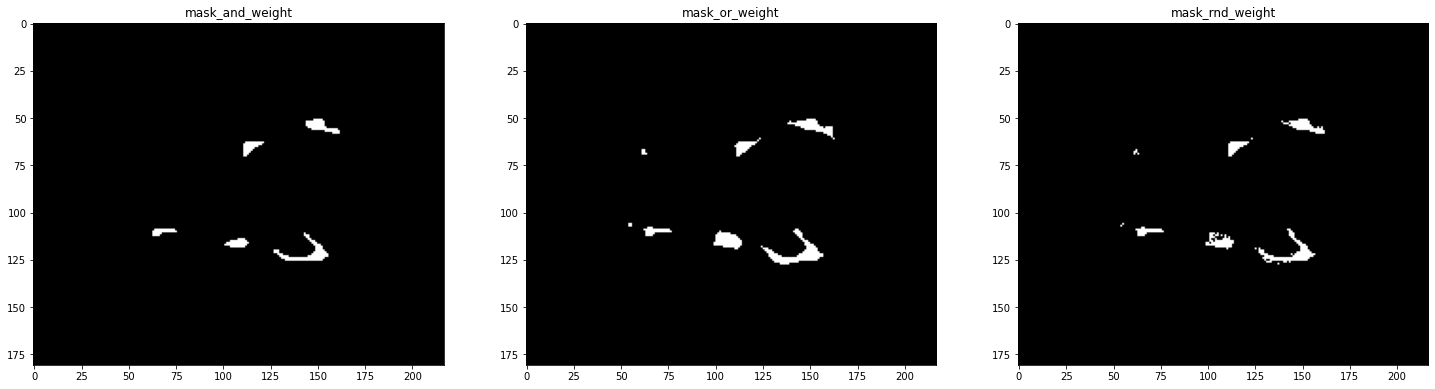

In [9]:
#root = '/content/gdrive/MyDrive/ImageVedioPrecessingProject/training/'
#mask_or_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
#mask_and_weight=np.zeros((fig_shape[0], fig_shape[1], n), dtype=np.int)
mask_and_weight, mask_or_weight, mask_rnd_weight = weight_ground_truth(mask1_path, mask2_path)
plt.figure(figsize=(25,10))
plt.subplot(1,3,1)
plt.imshow(mask_and_weight[:,:,90],'gray')
plt.title('mask_and_weight')
plt.subplot(1,3,2)
plt.imshow(mask_or_weight[:,:,90],'gray')
plt.title('mask_or_weight')
plt.subplot(1,3,3)
plt.imshow(mask_rnd_weight[:,:,90],'gray')
plt.title('mask_rnd_weight')

## 3) Make the custom dataset

In [6]:
second_path_list = ['training01/','training02/','training03/','training04/','training05/']
mri_list = []
mask1_list = []
mask2_list = []
for i in range(5):
    timepoint1_path = os.path.join(datapath_root, second_path_list[i], 'preprocessed/*_01_*.nii')
    timepoint2_path = os.path.join(datapath_root, second_path_list[i], 'preprocessed/*_02_*.nii')
    timepoint3_path = os.path.join(datapath_root, second_path_list[i], 'preprocessed/*_03_*.nii')
    timepoint4_path = os.path.join(datapath_root, second_path_list[i], 'preprocessed/*_04_*.nii')
    if i==2:
        timepoint5_path = os.path.join(datapath_root, second_path_list[i], 'preprocessed/*_05_*.nii')
    mask1_path = os.path.join(datapath_root, second_path_list[i], 'masks/*1.nii')
    mask2_path = os.path.join(datapath_root, second_path_list[i], 'masks/*2.nii')
    timepoint1_list = sorted(glob.glob(timepoint1_path))
    timepoint2_list = sorted(glob.glob(timepoint2_path))
    timepoint3_list = sorted(glob.glob(timepoint3_path))
    timepoint4_list = sorted(glob.glob(timepoint4_path))
    if i==2:
        timepoint5_list = sorted(glob.glob(timepoint5_path))
    mri_list.append(timepoint1_list)
    mri_list.append(timepoint2_list)
    mri_list.append(timepoint3_list)
    mri_list.append(timepoint4_list)
    if i==2:
        mri_list.append(timepoint5_list)
    mask1_list = mask1_list + sorted(glob.glob(mask1_path))
    mask2_list = mask2_list + sorted(glob.glob(mask2_path))
print('Data Collected:', len(mri_list))
print('Mask1 Collected:', len(mask1_list))
print('Mask2 Collected:', len(mask2_list))
print(mri_list[0])

Data Collected: 21
Mask1 Collected: 21
Mask2 Collected: 21
['/scratch/yl7692/training/training01/preprocessed/training01_01_flair_pp.nii', '/scratch/yl7692/training/training01/preprocessed/training01_01_mprage_pp.nii', '/scratch/yl7692/training/training01/preprocessed/training01_01_pd_pp.nii', '/scratch/yl7692/training/training01/preprocessed/training01_01_t2_pp.nii']


<ipython-input-12-bbfdd6332bd2>:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  ex = nib.load(mri_list[0][index+i]).get_data()
<ipython-input-12-bbfdd6332bd2>:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  ms1 = nib.load(mask1_list[0]).get_data()
<ipython-input-12-bbfdd6332bd2>:13: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.

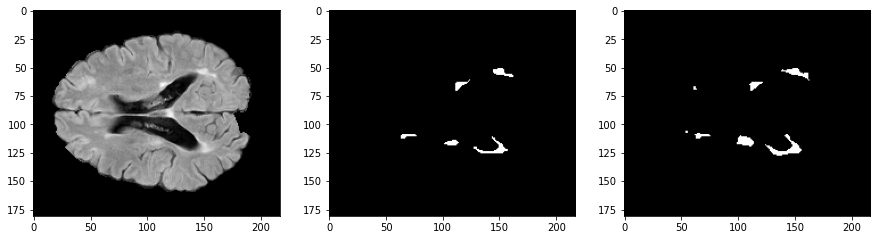

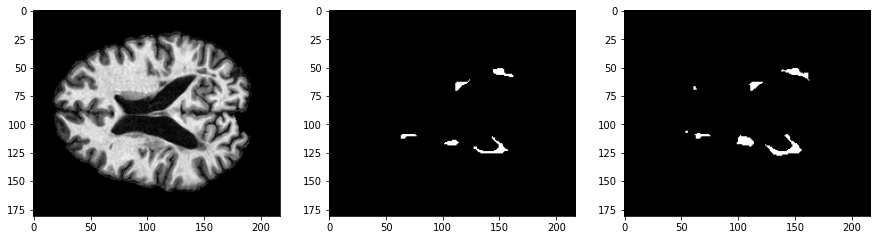

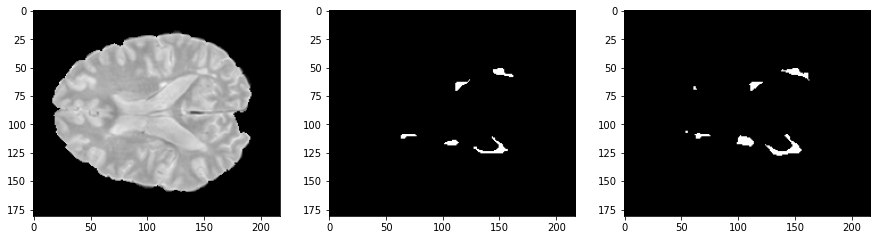

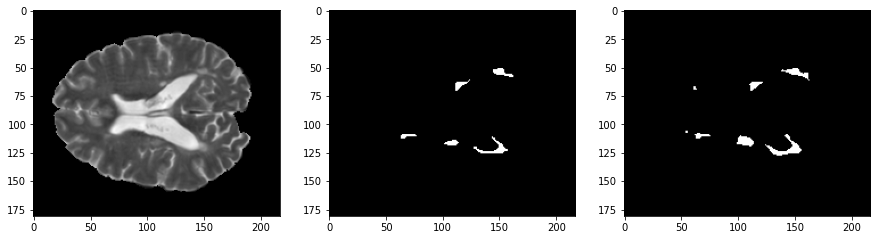

In [12]:
# 0-3:training 1(4 time points)
# 4-7:training 2(4 time points)
# 8-12:training 3(5 time points)
# 13-16:training 4(4 time points)
# 17-20:training 5(4 time points)
# order in one training set: t2_flair_weight, t1_weight, pd_weight, t2_weight

#Display one timepoint(4 type MRI) for one of the training set
index = 0
for i in range(4):
    ex = nib.load(mri_list[0][index+i]).get_data()
    ms1 = nib.load(mask1_list[0]).get_data()
    ms2 = nib.load(mask2_list[0]).get_data()
    plt.figure(figsize=(15,25))
    plt.subplot(5,3,3*i+1)
    plt.imshow(ex[:,:,90],'gray')
    plt.subplot(5,3,3*i+2)
    plt.imshow(ms1[:,:,90],'gray')
    plt.subplot(5,3,3*i+3)
    plt.imshow(ms2[:,:,90],'gray')

In [7]:
from random import shuffle
def shuffle_two_lists(listA, listB, listC):
    temp = list(zip(listA, listB, listC))
    shuffle(temp)
    return zip(*temp)
train_split_ratio = 0.8
test_split_ratio = 0.1
num_samples = len(mri_list)

train_size = int(num_samples * train_split_ratio)
test_size = int(num_samples * test_split_ratio)
val_size = num_samples - train_size - test_size
mri_list_shuffled, mask1_list_shuffled, mask2_list_shuffled = shuffle_two_lists(mri_list, mask1_list, mask2_list)

train_img_list, train_label1_list, train_label2_list = mri_list_shuffled[:train_size], mask1_list_shuffled[:train_size], mask2_list_shuffled[:train_size]
val_img_list, val_label1_list, val_label2_list = mri_list_shuffled[train_size:train_size+ val_size], mask1_list_shuffled[train_size:train_size + val_size], mask2_list_shuffled[train_size:train_size + val_size]
test_img_list, test_label1_list, test_label2_list = mri_list_shuffled[train_size+ val_size:], mask1_list_shuffled[train_size+ val_size:], mask2_list_shuffled[train_size+ val_size:]

print ("Training set size: {}". format(len(train_img_list)))
print ("Validation set size: {}". format(len(val_img_list)))
print ("Test set size: {}". format(len(test_img_list)))

Training set size: 16
Validation set size: 3
Test set size: 2


In [8]:
class MRIDataset(Dataset):
    def __init__(self, img_path_list, label1_path_list, label2_path_list, RULE = 'and', IF_TRAIN= False):
        self.mri_path_list = img_path_list
        self.label1_path_list = label1_path_list
        self.label2_path_list = label2_path_list
        self.rule = RULE
        self.IF_TRAIN = IF_TRAIN
        #self.transform=transforms.Compose([transforms.Normalize((0.5,),(0.5,))])
        self.mri_list, self.mask1_list, self.mask2_list, self.mask_and_list, self.mask_or_list, self.mask_rnd_list = self.preprocess() 

    def __len__(self):
        return len(self.mri_list)

    def preprocess(self):
        mri_list, mask1_list, mask2_list, mask_and_list, mask_or_list, mask_rnd_list = [], [], [], [], [], []
        for idx in tqdm(range(len(self.mri_path_list))):
            mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
            mri_t2f = (mri_t2f-mri_t2f.min())/(mri_t2f.max()-mri_t2f.min())
            
            mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
            mri_t1w = (mri_t1w-mri_t1w.min())/(mri_t1w.max()-mri_t1w.min())
            
            mri_pd = torch.Tensor(nib.load(self.mri_path_list[idx][2]).get_data())
            mri_pd = (mri_pd-mri_pd.min())/(mri_pd.max()-mri_pd.min())
            
            mri_t2w = torch.Tensor(nib.load(self.mri_path_list[idx][3]).get_data())
            mri_t2w = (mri_t2w-mri_t2w.min())/(mri_t2w.max()-mri_t2w.min())
            
            mri = torch.cat((mri_t1w.unsqueeze(0),mri_t2w.unsqueeze(0),mri_pd.unsqueeze(0),mri_t2f.unsqueeze(0)),axis=0)
            #mri = self.transform(mri)
            mask_and, mask_or, mask_rnd = weight_ground_truth(self.label1_path_list[idx], self.label2_path_list[idx])
            mask1 = torch.Tensor(nib.load(self.label1_path_list[idx]).get_data())
            mask2 = torch.Tensor(nib.load(self.label2_path_list[idx]).get_data())
            
            mri_list.append(mri)
            mask1_list.append(mask1)
            mask2_list.append(mask2)
            mask_and_list.append(mask_and)
            mask_or_list.append(mask_or)
            mask_rnd_list.append(mask_rnd)
        return mri_list, mask1_list, mask2_list, mask_and_list, mask_or_list, mask_rnd_list

    def __getitem__ (self,idx):
        img = self.mri_list[idx]
        if self.rule=='and':
            mask = self.mask_and_list[idx]
        elif self.rule=='or':
            mask = self.mask_or_list[idx]
        elif self.rule=='random':
            mask = self.mask_rnd_list[idx]
        elif self.rule=='mask1':
            mask = self.mask1_list[idx]
        elif self.rule=='mask2':
            mask = self.mask2_list[idx]
            
        label = torch.Tensor(mask)

        return img, label

In [9]:
dataset = MRIDataset(test_img_list, test_label1_list, test_label2_list, RULE = 'and', IF_TRAIN= True)

  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-8-cc23401311c6>:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
<ipython-input-8-cc23401311c6>:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
<ipython-input-8-cc23401311c6>:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predi

torch.Size([4, 181, 217, 181])
torch.Size([181, 217, 181])
1.0
1.0
1.0
1.0


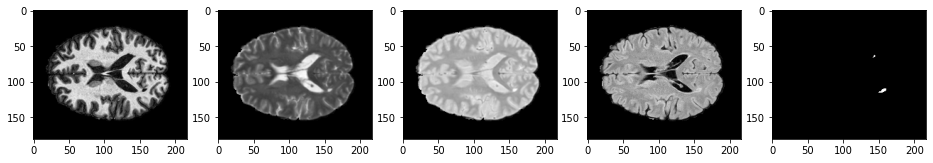

In [16]:
img, mask = dataset[0]
print(img.shape)
print(mask.shape)
plt.figure(figsize = (16,32))
plt.subplot(1,5,1)
plt.imshow(img[0,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.subplot(1,5,2)
plt.imshow(img[1,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.subplot(1,5,3)
plt.imshow(img[2,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.subplot(1,5,4)
plt.imshow(img[3,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.subplot(1,5,5)
plt.imshow(mask.cpu().numpy()[:,:,90],'gray')
print(img[0,:,:,:].cpu().numpy().max())
print(img[1,:,:,:].cpu().numpy().max())
print(img[2,:,:,:].cpu().numpy().max())
print(img[3,:,:,:].cpu().numpy().max())

In [13]:
train_dataset = MRIDataset(train_img_list, train_label1_list, train_label2_list, RULE = 'and', IF_TRAIN= True)
val_dataset = MRIDataset(val_img_list, val_label1_list, val_label2_list, RULE = 'and', IF_TRAIN= False)
test_dataset = MRIDataset(test_img_list, test_label1_list, test_label2_list, RULE = 'and', IF_TRAIN= False)

  0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-8-cc23401311c6>:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
<ipython-input-8-cc23401311c6>:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
<ipython-input-8-cc23401311c6>:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more pred

In [14]:
NUM_EPOCH = 500
BATCH_SIZE = 8
LR = 0.0001

In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=0)

# 3.Build the Network

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
class SelfAttention_3D(nn.Module):
    def __init__(self, feature_dims, dim_q):
        super(SelfAttention_3D, self).__init__()
        self.fc_q1 = nn.Linear(feature_dims, dim_q)
        self.fc_k1 = nn.Linear(feature_dims, dim_q)
        self.fc_v1 = nn.Linear(feature_dims, dim_q)
        
        self.fc_q2 = nn.Linear(feature_dims, dim_q)
        self.fc_k2 = nn.Linear(feature_dims, dim_q)
        self.fc_v2 = nn.Linear(feature_dims, dim_q)
        
        self.fc_q3 = nn.Linear(feature_dims, dim_q)
        self.fc_k3 = nn.Linear(feature_dims, dim_q)
        self.fc_v3 = nn.Linear(feature_dims, dim_q)
        
        self.fc_o = nn.Linear(3*dim_q, feature_dims)

    def forward(self, input_data):
        # Expect input_data to be of shape (batch_size, channels, l, w, h).
        batch_size, channels, l, w, h  = input_data.size()
        # (batch_size, n_pixels, channels)
        input_data = input_data.flatten().reshape(batch_size, channels, -1)

        # Linear transforms(head_1).
        queries1 = self.fc_q1(input=input_data)  # (batch_size, feature_dims, dim_q)
        keys1 = self.fc_k1(input=input_data)  # (batch_size, feature_dims, dim_q)
        values1 = self.fc_v1(input=input_data)  # (batch_size, feature_dims, dim_q)
        
        # Attention matrix1.
        dot1 = torch.bmm(queries1, keys1.transpose(1, 2))  # (batch_size, channels, channels)
        scaled_dot1 = torch.div(dot1, torch.sqrt(torch.tensor(l*w*h).float())) # scale
        atten_matrix1 = F.softmax(scaled_dot1, dim=1)
        atten_weighted1 = torch.bmm(atten_matrix1, values1)
        
        # Linear transforms(head_2).
        queries2 = self.fc_q2(input=input_data)  # (batch_size, feature_dims, dim_q)
        keys2 = self.fc_k2(input=input_data)  # (batch_size, feature_dims, dim_q)
        values2 = self.fc_v2(input=input_data)  # (batch_size, feature_dims, dim_q)
        
        # Attention matrix2.
        dot2 = torch.bmm(queries2, keys2.transpose(1, 2))  # (batch_size, channels, channels)
        scaled_dot2 = torch.div(dot2, torch.sqrt(torch.tensor(l*w*h).float())) # scale
        atten_matrix2 = F.softmax(scaled_dot2, dim=1)
        atten_weighted2 = torch.bmm(atten_matrix2, values2)
        
        # Linear transforms(head_3).
        queries3 = self.fc_q3(input=input_data)  # (batch_size, feature_dims, dim_q)
        keys3 = self.fc_k3(input=input_data)  # (batch_size, feature_dims, dim_q)
        values3 = self.fc_v3(input=input_data)  # (batch_size, feature_dims, dim_q)
        
        # Attention matrix3.
        dot3 = torch.bmm(queries3, keys3.transpose(1, 2))  # (batch_size, channels, channels)
        scaled_dot3 = torch.div(dot3, torch.sqrt(torch.tensor(l*w*h).float())) # scale
        atten_matrix3 = F.softmax(scaled_dot3, dim=1)
        atten_weighted3 = torch.bmm(atten_matrix3, values3)
        
        catlayer = torch.cat((atten_weighted1,atten_weighted2,atten_weighted3),dim=2)
        output = self.fc_o(catlayer).flatten().reshape(batch_size, channels, l, w, h)
        
        return output

In [18]:
class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x
    
class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv3d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x
    
    
class Attention_block(nn.Module):
    """
    Attention Block
    """

    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

    
class AttU_Net(nn.Module):
    """
    Attention Unet implementation
    Paper: https://arxiv.org/abs/1804.03999
    """
    def __init__(self, img_ch=4, output_ch=1):
        super(AttU_Net, self).__init__()

        n1 = 4
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        #filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        self.Maxpool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        
        self.attention1 = SelfAttention_3D(feature_dims=22*27*22, dim_q=10)
        self.attention2 = SelfAttention_3D(feature_dims=45*54*45, dim_q=10)
        #self.attention3 = SelfAttention_3D(feature_dims=91*109*91, dim_q=10)
        #self.attention4 = SelfAttention_3D(feature_dims=181*217*181, dim_q=10)
        
        self.Up5 = up_conv(filters[4], filters[3])
        #self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        #self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        #self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        #self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv3d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

        #self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.Conv1(x)
        #print("e1", e1.shape)
        e2 = self.Maxpool1((e1))
        e2 = self.Conv2(e2)
        #print("e2", e2.shape)
        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)
        #print("e3", e3.shape)
        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)
        #print("e4", e4.shape)
        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)
        #print("e5", e5.shape)
        #print("############")
        d5 = self.Up5(e5)
        #print(d5.shape)
        #e4 = e4[:,:,:,0:-1,:]
        #print("e4 new", e4.shape)
        
        #x4 = self.Att5(g=d5, x=e4)
        x4 = self.attention1(e4)
        #print("x4 new", x4.shape)
       
        #print("d5 new", d5.shape)
        d5 = torch.cat((x4[:,:,:,0:-1,:], d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        #e3 = e3[:,:,0:-1,0:-2,0:-1]
        #print("e3 new", e3.shape)
        #x3 = self.Att4(g=d4, x=e3)
        
        x3 = self.attention2(e3)
        #print("x3 new", x3.shape)
        d4 = torch.cat((x3[:,:,0:-1,0:-2,0:-1], d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        e2 = e2[:,:,0:-2,0:-4,0:-2]
        #print("e2 new", e2.shape)
        #x2 = self.Att3(g=d3, x=e2)
        #x2 = self.attention3(e2)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        #print("d2", d2.shape)
        padding = nn.ConstantPad3d(((2, 3, 4, 5, 2, 3)), 0)
        d2 = padding(d2)
        #print("d2 new", d2.shape)
        #print("e1", e1.shape)
        #x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)


      #  out = self.active(out)

        return out

# 4.Dice Loss

In [19]:
# define dice coefficient
def dice_coeff(pred, target):
    smooth = 1
    # First let's flatten the matrix to [Batch Size, -1]
    # The flatten operation does not afftect the computation of the above equation
    num = pred.size(0)
    m1 = pred. view(num, -1). float() # Flatten
    m2 = target. view(num, -1). float() # Flatten
    # Then we compute the intersection and the sum of cardinality
    intersection = 2*torch.sum(m1*m2,dim= 1) + smooth
    cardinality = torch.sum(m1**2,dim= 1) + torch.sum(m2**2,dim= 1) + smooth
    # Followed by Dice
    dice = intersection/cardinality
    return dice.mean()
# define SoftDICE loss as 1 - SoftDICE
class SoftDICELoss(nn. Module):
    def __init__(self, smooth = 1):
        super(SoftDICELoss, self). __init__()
        self. smooth = smooth
    def forward(self, pred, target):
        loss = 1 - dice_coeff(pred, target)
        return loss.mean()

# 5.Training

In [20]:
def train_epoch(net, data_loader, optimizer, criterion, epoch):

    net = net.train()
    optimizer.zero_grad()
    loss_stat = []
    for i, img_mask in enumerate(data_loader):
        img, mask = img_mask

        img = img.to(device)
        mask = mask.to(device)

        pred = net(img)

        loss = criterion(pred, mask)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_stat += [loss.item()]*img.shape[0]
        print ("Epoch {}: [{}/{}] Loss: {:.3f}". format(epoch, len(data_loader), len(data_loader),np. mean(loss_stat)))
    return np.mean(loss_stat)

In [38]:
def eval_epoch(net, data_loader, metric, criterion):
    # set model in eval mode to avoid updating BN layer
    net = net.eval()
    
    metric_stat = []
    val_loss_stat = []
    for i, img_mask in enumerate(data_loader):
        img, mask = img_mask
        # send data to device
        img = img.to(device)
        mask = mask.to(device)
        # feed data to the model. No need to compute grad.
        with torch.no_grad():
            pred = net(img)
            val_loss = criterion(pred, mask)
            
        # eval the results using DICE function as the metric
        # Convert probability to prediction mask
        pred = pred>0.8
        err = dice_coeff(pred, mask)
        metric_stat += [err.item()]*img.shape[0]
        val_loss_stat += [val_loss.item()]*img.shape[0]
        
    print ("Dice: {:.3f}  Val Loss: {:.3f} ".format(np.mean(metric_stat), np.mean(val_loss_stat)))
    
    return np.mean(val_loss_stat), np.mean(metric_stat)

In [22]:
net = AttU_Net(4,1).to(device)
print(net)
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

AttU_Net(
  (Maxpool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, m

In [23]:
optimizer = optim.Adam(net.parameters(), lr= LR)
criterion = SoftDICELoss()

train_loss_list = []
val_loss_list = []
dice_list = []

In [24]:
for epoch in tqdm(range(NUM_EPOCH)):    
    loss = train_epoch(net, train_loader, optimizer, criterion, epoch)
    val_loss, dice = eval_epoch(net, val_loader, dice_coeff, criterion)
    
    # Record losses for each epoch
    train_loss_list.append(loss)
    val_loss_list.append(val_loss)
    dice_list.append(dice)
    
    # Save the model after each epoch
    if os.path.isdir(SAVE_PATH):
        torch.save(net.state_dict(),SAVE_PATH + 'MRISegEpoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(SAVE_PATH, exist_ok=True)
        torch.save(net.state_dict(),SAVE_PATH + 'MRISegEpoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved to {}'.format(epoch + 1, SAVE_PATH + 'MRISegEpoch{}.pth'.format(epoch + 1)))  

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0: [2/2] Loss: 0.995
Epoch 0: [2/2] Loss: 0.995
Dice: 0.002  Val Loss: 0.995 


  0%|          | 1/500 [00:23<3:12:57, 23.20s/it]

Checkpoint 1 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch1.pth
Epoch 1: [2/2] Loss: 0.996
Epoch 1: [2/2] Loss: 0.994
Dice: 0.002  Val Loss: 0.995 


  0%|          | 2/500 [00:45<3:06:35, 22.48s/it]

Checkpoint 2 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch2.pth
Epoch 2: [2/2] Loss: 0.996
Epoch 2: [2/2] Loss: 0.993
Dice: 0.002  Val Loss: 0.995 


  1%|          | 3/500 [01:07<3:05:19, 22.37s/it]

Checkpoint 3 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch3.pth
Epoch 3: [2/2] Loss: 0.991
Epoch 3: [2/2] Loss: 0.992


  1%|          | 4/500 [01:29<3:03:40, 22.22s/it]

Dice: 0.002  Val Loss: 0.995 
Checkpoint 4 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch4.pth
Epoch 4: [2/2] Loss: 0.994
Epoch 4: [2/2] Loss: 0.991


  1%|          | 5/500 [01:51<3:02:27, 22.12s/it]

Dice: 0.002  Val Loss: 0.995 
Checkpoint 5 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch5.pth
Epoch 5: [2/2] Loss: 0.992
Epoch 5: [2/2] Loss: 0.990
Dice: 0.002  Val Loss: 0.995 


  1%|          | 6/500 [02:13<3:02:00, 22.11s/it]

Checkpoint 6 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch6.pth
Epoch 6: [2/2] Loss: 0.989
Epoch 6: [2/2] Loss: 0.988
Dice: 0.002  Val Loss: 0.994 


  1%|▏         | 7/500 [02:35<3:01:22, 22.07s/it]

Checkpoint 7 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch7.pth
Epoch 7: [2/2] Loss: 0.993
Epoch 7: [2/2] Loss: 0.987
Dice: 0.002  Val Loss: 0.994 


  2%|▏         | 8/500 [02:57<3:01:20, 22.11s/it]

Checkpoint 8 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch8.pth
Epoch 8: [2/2] Loss: 0.981
Epoch 8: [2/2] Loss: 0.985
Dice: 0.002  Val Loss: 0.994 


  2%|▏         | 9/500 [03:19<3:00:56, 22.11s/it]

Checkpoint 9 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch9.pth
Epoch 9: [2/2] Loss: 0.988
Epoch 9: [2/2] Loss: 0.984
Dice: 0.002  Val Loss: 0.994 


  2%|▏         | 10/500 [03:42<3:01:02, 22.17s/it]

Checkpoint 10 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch10.pth
Epoch 10: [2/2] Loss: 0.994
Epoch 10: [2/2] Loss: 0.982
Dice: 0.002  Val Loss: 0.993 


  2%|▏         | 11/500 [04:04<3:00:27, 22.14s/it]

Checkpoint 11 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch11.pth
Epoch 11: [2/2] Loss: 0.974
Epoch 11: [2/2] Loss: 0.979
Dice: 0.002  Val Loss: 0.993 


  2%|▏         | 12/500 [04:26<3:00:04, 22.14s/it]

Checkpoint 12 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch12.pth
Epoch 12: [2/2] Loss: 0.970
Epoch 12: [2/2] Loss: 0.976


  3%|▎         | 13/500 [04:48<2:59:09, 22.07s/it]

Dice: 0.002  Val Loss: 0.993 
Checkpoint 13 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch13.pth
Epoch 13: [2/2] Loss: 0.980
Epoch 13: [2/2] Loss: 0.973
Dice: 0.002  Val Loss: 0.993 


  3%|▎         | 14/500 [05:10<2:58:41, 22.06s/it]

Checkpoint 14 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch14.pth
Epoch 14: [2/2] Loss: 0.966
Epoch 14: [2/2] Loss: 0.970
Dice: 0.002  Val Loss: 0.993 


  3%|▎         | 15/500 [05:32<2:58:27, 22.08s/it]

Checkpoint 15 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch15.pth
Epoch 15: [2/2] Loss: 0.960
Epoch 15: [2/2] Loss: 0.967


  3%|▎         | 16/500 [05:54<2:58:03, 22.07s/it]

Dice: 0.002  Val Loss: 0.992 
Checkpoint 16 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch16.pth
Epoch 16: [2/2] Loss: 0.970
Epoch 16: [2/2] Loss: 0.964
Dice: 0.002  Val Loss: 0.993 


  3%|▎         | 17/500 [06:16<2:57:40, 22.07s/it]

Checkpoint 17 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch17.pth
Epoch 17: [2/2] Loss: 0.967
Epoch 17: [2/2] Loss: 0.960
Dice: 0.002  Val Loss: 0.992 


  4%|▎         | 18/500 [06:38<2:57:30, 22.10s/it]

Checkpoint 18 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch18.pth
Epoch 18: [2/2] Loss: 0.985
Epoch 18: [2/2] Loss: 0.963
Dice: 0.002  Val Loss: 0.992 


  4%|▍         | 19/500 [07:00<2:57:44, 22.17s/it]

Checkpoint 19 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch19.pth
Epoch 19: [2/2] Loss: 0.951
Epoch 19: [2/2] Loss: 0.957
Dice: 0.002  Val Loss: 0.992 


  4%|▍         | 20/500 [07:23<2:57:07, 22.14s/it]

Checkpoint 20 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch20.pth
Epoch 20: [2/2] Loss: 0.949
Epoch 20: [2/2] Loss: 0.950
Dice: 0.002  Val Loss: 0.991 


  4%|▍         | 21/500 [07:45<2:56:48, 22.15s/it]

Checkpoint 21 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch21.pth
Epoch 21: [2/2] Loss: 0.945
Epoch 21: [2/2] Loss: 0.947


  4%|▍         | 22/500 [08:07<2:56:05, 22.10s/it]

Dice: 0.002  Val Loss: 0.990 
Checkpoint 22 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch22.pth
Epoch 22: [2/2] Loss: 0.953
Epoch 22: [2/2] Loss: 0.945


  5%|▍         | 23/500 [08:29<2:55:19, 22.05s/it]

Dice: 0.003  Val Loss: 0.989 
Checkpoint 23 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch23.pth
Epoch 23: [2/2] Loss: 0.962
Epoch 23: [2/2] Loss: 0.942


  5%|▍         | 24/500 [08:51<2:54:51, 22.04s/it]

Dice: 0.004  Val Loss: 0.989 
Checkpoint 24 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch24.pth
Epoch 24: [2/2] Loss: 0.947
Epoch 24: [2/2] Loss: 0.938


  5%|▌         | 25/500 [09:13<2:54:22, 22.03s/it]

Dice: 0.005  Val Loss: 0.986 
Checkpoint 25 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch25.pth
Epoch 25: [2/2] Loss: 0.946
Epoch 25: [2/2] Loss: 0.935
Dice: 0.005  Val Loss: 0.981 


  5%|▌         | 26/500 [09:38<3:01:48, 23.01s/it]

Checkpoint 26 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch26.pth
Epoch 26: [2/2] Loss: 0.924
Epoch 26: [2/2] Loss: 0.927
Dice: 0.005  Val Loss: 0.977 


  5%|▌         | 27/500 [10:03<3:07:07, 23.74s/it]

Checkpoint 27 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch27.pth
Epoch 27: [2/2] Loss: 0.936
Epoch 27: [2/2] Loss: 0.922
Dice: 0.007  Val Loss: 0.961 


  6%|▌         | 28/500 [10:26<3:04:55, 23.51s/it]

Checkpoint 28 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch28.pth
Epoch 28: [2/2] Loss: 0.919
Epoch 28: [2/2] Loss: 0.918
Dice: 0.008  Val Loss: 0.949 


  6%|▌         | 29/500 [10:52<3:08:53, 24.06s/it]

Checkpoint 29 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch29.pth
Epoch 29: [2/2] Loss: 0.910
Epoch 29: [2/2] Loss: 0.910
Dice: 0.008  Val Loss: 0.955 


  6%|▌         | 30/500 [11:17<3:11:31, 24.45s/it]

Checkpoint 30 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch30.pth
Epoch 30: [2/2] Loss: 0.909
Epoch 30: [2/2] Loss: 0.906
Dice: 0.009  Val Loss: 0.943 


  6%|▌         | 31/500 [11:42<3:13:16, 24.73s/it]

Checkpoint 31 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch31.pth
Epoch 31: [2/2] Loss: 0.927
Epoch 31: [2/2] Loss: 0.902
Dice: 0.008  Val Loss: 0.958 


  6%|▋         | 32/500 [12:08<3:15:31, 25.07s/it]

Checkpoint 32 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch32.pth
Epoch 32: [2/2] Loss: 0.880
Epoch 32: [2/2] Loss: 0.930
Dice: 0.010  Val Loss: 0.944 


  7%|▋         | 33/500 [12:34<3:15:44, 25.15s/it]

Checkpoint 33 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch33.pth
Epoch 33: [2/2] Loss: 0.983
Epoch 33: [2/2] Loss: 0.935


  7%|▋         | 34/500 [12:56<3:07:57, 24.20s/it]

Dice: 0.007  Val Loss: 0.947 
Checkpoint 34 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch34.pth
Epoch 34: [2/2] Loss: 0.936
Epoch 34: [2/2] Loss: 0.910
Dice: 0.003  Val Loss: 0.970 


  7%|▋         | 35/500 [13:18<3:02:35, 23.56s/it]

Checkpoint 35 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch35.pth
Epoch 35: [2/2] Loss: 0.865
Epoch 35: [2/2] Loss: 0.898
Dice: 0.003  Val Loss: 0.973 


  7%|▋         | 36/500 [13:40<2:58:42, 23.11s/it]

Checkpoint 36 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch36.pth
Epoch 36: [2/2] Loss: 0.904
Epoch 36: [2/2] Loss: 0.897


  7%|▋         | 37/500 [14:02<2:55:30, 22.74s/it]

Dice: 0.002  Val Loss: 0.992 
Checkpoint 37 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch37.pth
Epoch 37: [2/2] Loss: 0.929
Epoch 37: [2/2] Loss: 0.886


  8%|▊         | 38/500 [14:24<2:53:22, 22.52s/it]

Dice: 0.002  Val Loss: 0.992 
Checkpoint 38 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch38.pth
Epoch 38: [2/2] Loss: 0.876
Epoch 38: [2/2] Loss: 0.873


  8%|▊         | 39/500 [14:46<2:51:43, 22.35s/it]

Dice: 0.002  Val Loss: 0.992 
Checkpoint 39 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch39.pth
Epoch 39: [2/2] Loss: 0.837
Epoch 39: [2/2] Loss: 0.894


  8%|▊         | 40/500 [15:08<2:50:37, 22.26s/it]

Dice: 0.002  Val Loss: 0.993 
Checkpoint 40 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch40.pth
Epoch 40: [2/2] Loss: 0.862
Epoch 40: [2/2] Loss: 0.859


  8%|▊         | 41/500 [15:30<2:49:34, 22.17s/it]

Dice: 0.002  Val Loss: 0.993 
Checkpoint 41 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch41.pth
Epoch 41: [2/2] Loss: 0.855
Epoch 41: [2/2] Loss: 0.852
Dice: 0.002  Val Loss: 0.995 


  8%|▊         | 42/500 [15:52<2:49:35, 22.22s/it]

Checkpoint 42 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch42.pth
Epoch 42: [2/2] Loss: 0.922
Epoch 42: [2/2] Loss: 0.864


  9%|▊         | 43/500 [16:14<2:48:45, 22.16s/it]

Dice: 0.002  Val Loss: 0.992 
Checkpoint 43 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch43.pth
Epoch 43: [2/2] Loss: 0.805
Epoch 43: [2/2] Loss: 0.863


  9%|▉         | 44/500 [16:36<2:48:05, 22.12s/it]

Dice: 0.002  Val Loss: 0.989 
Checkpoint 44 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch44.pth
Epoch 44: [2/2] Loss: 0.837
Epoch 44: [2/2] Loss: 0.836


  9%|▉         | 45/500 [16:58<2:47:11, 22.05s/it]

Dice: 0.003  Val Loss: 0.985 
Checkpoint 45 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch45.pth
Epoch 45: [2/2] Loss: 0.825
Epoch 45: [2/2] Loss: 0.824
Dice: 0.003  Val Loss: 0.988 


  9%|▉         | 46/500 [17:20<2:46:50, 22.05s/it]

Checkpoint 46 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch46.pth
Epoch 46: [2/2] Loss: 0.975
Epoch 46: [2/2] Loss: 0.892
Dice: 0.004  Val Loss: 0.980 


  9%|▉         | 47/500 [17:42<2:46:30, 22.05s/it]

Checkpoint 47 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch47.pth
Epoch 47: [2/2] Loss: 0.768
Epoch 47: [2/2] Loss: 0.839


 10%|▉         | 48/500 [18:04<2:45:58, 22.03s/it]

Dice: 0.013  Val Loss: 0.944 
Checkpoint 48 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch48.pth
Epoch 48: [2/2] Loss: 0.834
Epoch 48: [2/2] Loss: 0.831
Dice: 0.028  Val Loss: 0.899 


 10%|▉         | 49/500 [18:26<2:46:09, 22.11s/it]

Checkpoint 49 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch49.pth
Epoch 49: [2/2] Loss: 0.832
Epoch 49: [2/2] Loss: 0.832
Dice: 0.008  Val Loss: 0.962 


 10%|█         | 50/500 [18:50<2:49:11, 22.56s/it]

Checkpoint 50 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch50.pth
Epoch 50: [2/2] Loss: 0.755
Epoch 50: [2/2] Loss: 0.835
Dice: 0.002  Val Loss: 0.993 


 10%|█         | 51/500 [19:12<2:47:51, 22.43s/it]

Checkpoint 51 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch51.pth
Epoch 51: [2/2] Loss: 0.832
Epoch 51: [2/2] Loss: 0.818


 10%|█         | 52/500 [19:34<2:46:24, 22.29s/it]

Dice: 0.002  Val Loss: 0.990 
Checkpoint 52 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch52.pth
Epoch 52: [2/2] Loss: 0.844
Epoch 52: [2/2] Loss: 0.830
Dice: 0.003  Val Loss: 0.987 


 11%|█         | 53/500 [19:56<2:45:29, 22.21s/it]

Checkpoint 53 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch53.pth
Epoch 53: [2/2] Loss: 0.826
Epoch 53: [2/2] Loss: 0.825


 11%|█         | 54/500 [20:18<2:44:46, 22.17s/it]

Dice: 0.003  Val Loss: 0.983 
Checkpoint 54 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch54.pth
Epoch 54: [2/2] Loss: 0.785
Epoch 54: [2/2] Loss: 0.811


 11%|█         | 55/500 [20:40<2:43:48, 22.09s/it]

Dice: 0.003  Val Loss: 0.980 
Checkpoint 55 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch55.pth
Epoch 55: [2/2] Loss: 0.817
Epoch 55: [2/2] Loss: 0.872
Dice: 0.003  Val Loss: 0.986 


 11%|█         | 56/500 [21:02<2:43:22, 22.08s/it]

Checkpoint 56 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch56.pth
Epoch 56: [2/2] Loss: 0.778
Epoch 56: [2/2] Loss: 0.825
Dice: 0.003  Val Loss: 0.981 


 11%|█▏        | 57/500 [21:24<2:42:57, 22.07s/it]

Checkpoint 57 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch57.pth
Epoch 57: [2/2] Loss: 0.761
Epoch 57: [2/2] Loss: 0.797
Dice: 0.003  Val Loss: 0.987 


 12%|█▏        | 58/500 [21:46<2:42:29, 22.06s/it]

Checkpoint 58 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch58.pth
Epoch 58: [2/2] Loss: 0.841
Epoch 58: [2/2] Loss: 0.777


 12%|█▏        | 59/500 [22:08<2:41:50, 22.02s/it]

Dice: 0.006  Val Loss: 0.969 
Checkpoint 59 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch59.pth
Epoch 59: [2/2] Loss: 0.815
Epoch 59: [2/2] Loss: 0.857
Dice: 0.043  Val Loss: 0.900 


 12%|█▏        | 60/500 [22:30<2:41:58, 22.09s/it]

Checkpoint 60 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch60.pth
Epoch 60: [2/2] Loss: 0.861
Epoch 60: [2/2] Loss: 0.831


 12%|█▏        | 61/500 [22:52<2:41:12, 22.03s/it]

Dice: 0.035  Val Loss: 0.866 
Checkpoint 61 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch61.pth
Epoch 61: [2/2] Loss: 0.789
Epoch 61: [2/2] Loss: 0.823
Dice: 0.004  Val Loss: 0.973 


 12%|█▏        | 62/500 [23:15<2:41:46, 22.16s/it]

Checkpoint 62 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch62.pth
Epoch 62: [2/2] Loss: 0.809
Epoch 62: [2/2] Loss: 0.794
Dice: 0.003  Val Loss: 0.983 


 13%|█▎        | 63/500 [23:37<2:41:16, 22.14s/it]

Checkpoint 63 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch63.pth
Epoch 63: [2/2] Loss: 0.800
Epoch 63: [2/2] Loss: 0.799
Dice: 0.003  Val Loss: 0.985 


 13%|█▎        | 64/500 [23:59<2:40:49, 22.13s/it]

Checkpoint 64 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch64.pth
Epoch 64: [2/2] Loss: 0.794
Epoch 64: [2/2] Loss: 0.779


 13%|█▎        | 65/500 [24:21<2:40:02, 22.07s/it]

Dice: 0.003  Val Loss: 0.986 
Checkpoint 65 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch65.pth
Epoch 65: [2/2] Loss: 0.812
Epoch 65: [2/2] Loss: 0.785
Dice: 0.003  Val Loss: 0.980 


 13%|█▎        | 66/500 [24:43<2:39:37, 22.07s/it]

Checkpoint 66 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch66.pth
Epoch 66: [2/2] Loss: 0.804
Epoch 66: [2/2] Loss: 0.772
Dice: 0.007  Val Loss: 0.950 


 13%|█▎        | 67/500 [25:05<2:39:12, 22.06s/it]

Checkpoint 67 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch67.pth
Epoch 67: [2/2] Loss: 0.734
Epoch 67: [2/2] Loss: 0.767
Dice: 0.010  Val Loss: 0.930 


 14%|█▎        | 68/500 [25:27<2:38:48, 22.06s/it]

Checkpoint 68 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch68.pth
Epoch 68: [2/2] Loss: 0.839
Epoch 68: [2/2] Loss: 0.768
Dice: 0.050  Val Loss: 0.827 


 14%|█▍        | 69/500 [25:49<2:38:23, 22.05s/it]

Checkpoint 69 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch69.pth
Epoch 69: [2/2] Loss: 0.800
Epoch 69: [2/2] Loss: 0.756
Dice: 0.012  Val Loss: 0.925 


 14%|█▍        | 70/500 [26:11<2:38:08, 22.07s/it]

Checkpoint 70 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch70.pth
Epoch 70: [2/2] Loss: 0.830
Epoch 70: [2/2] Loss: 0.763


 14%|█▍        | 71/500 [26:33<2:37:33, 22.04s/it]

Dice: 0.017  Val Loss: 0.904 
Checkpoint 71 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch71.pth
Epoch 71: [2/2] Loss: 0.726
Epoch 71: [2/2] Loss: 0.764
Dice: 0.016  Val Loss: 0.911 


 14%|█▍        | 72/500 [26:55<2:37:19, 22.05s/it]

Checkpoint 72 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch72.pth
Epoch 72: [2/2] Loss: 0.877
Epoch 72: [2/2] Loss: 0.785


 15%|█▍        | 73/500 [27:17<2:36:36, 22.01s/it]

Dice: 0.005  Val Loss: 0.963 
Checkpoint 73 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch73.pth
Epoch 73: [2/2] Loss: 0.734
Epoch 73: [2/2] Loss: 0.769


 15%|█▍        | 74/500 [27:39<2:36:09, 21.99s/it]

Dice: 0.003  Val Loss: 0.977 
Checkpoint 74 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch74.pth
Epoch 74: [2/2] Loss: 0.738
Epoch 74: [2/2] Loss: 0.766
Dice: 0.003  Val Loss: 0.984 


 15%|█▌        | 75/500 [28:01<2:36:00, 22.02s/it]

Checkpoint 75 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch75.pth
Epoch 75: [2/2] Loss: 0.902
Epoch 75: [2/2] Loss: 0.845


 15%|█▌        | 76/500 [28:23<2:35:30, 22.01s/it]

Dice: 0.003  Val Loss: 0.988 
Checkpoint 76 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch76.pth
Epoch 76: [2/2] Loss: 0.911
Epoch 76: [2/2] Loss: 0.822
Dice: 0.003  Val Loss: 0.989 


 15%|█▌        | 77/500 [28:45<2:35:26, 22.05s/it]

Checkpoint 77 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch77.pth
Epoch 77: [2/2] Loss: 0.849
Epoch 77: [2/2] Loss: 0.769
Dice: 0.002  Val Loss: 0.990 


 16%|█▌        | 78/500 [29:08<2:36:12, 22.21s/it]

Checkpoint 78 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch78.pth
Epoch 78: [2/2] Loss: 0.686
Epoch 78: [2/2] Loss: 0.758
Dice: 0.002  Val Loss: 0.992 


 16%|█▌        | 79/500 [29:30<2:35:57, 22.23s/it]

Checkpoint 79 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch79.pth
Epoch 79: [2/2] Loss: 0.811
Epoch 79: [2/2] Loss: 0.799
Dice: 0.002  Val Loss: 0.993 


 16%|█▌        | 80/500 [29:52<2:35:44, 22.25s/it]

Checkpoint 80 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch80.pth
Epoch 80: [2/2] Loss: 0.888
Epoch 80: [2/2] Loss: 0.790


 16%|█▌        | 81/500 [30:14<2:34:46, 22.16s/it]

Dice: 0.002  Val Loss: 0.993 
Checkpoint 81 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch81.pth
Epoch 81: [2/2] Loss: 0.695
Epoch 81: [2/2] Loss: 0.799


 16%|█▋        | 82/500 [30:36<2:34:03, 22.11s/it]

Dice: 0.002  Val Loss: 0.993 
Checkpoint 82 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch82.pth
Epoch 82: [2/2] Loss: 0.946
Epoch 82: [2/2] Loss: 0.844
Dice: 0.003  Val Loss: 0.990 


 17%|█▋        | 83/500 [30:58<2:33:47, 22.13s/it]

Checkpoint 83 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch83.pth
Epoch 83: [2/2] Loss: 0.892
Epoch 83: [2/2] Loss: 0.800
Dice: 0.128  Val Loss: 0.874 


 17%|█▋        | 84/500 [31:21<2:33:38, 22.16s/it]

Checkpoint 84 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch84.pth
Epoch 84: [2/2] Loss: 0.788
Epoch 84: [2/2] Loss: 0.780


 17%|█▋        | 85/500 [31:43<2:32:45, 22.09s/it]

Dice: 0.139  Val Loss: 0.863 
Checkpoint 85 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch85.pth
Epoch 85: [2/2] Loss: 0.757
Epoch 85: [2/2] Loss: 0.819


 17%|█▋        | 86/500 [32:05<2:32:14, 22.06s/it]

Dice: 0.125  Val Loss: 0.864 
Checkpoint 86 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch86.pth
Epoch 86: [2/2] Loss: 0.836
Epoch 86: [2/2] Loss: 0.812
Dice: 0.125  Val Loss: 0.831 


 17%|█▋        | 87/500 [32:27<2:31:58, 22.08s/it]

Checkpoint 87 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch87.pth
Epoch 87: [2/2] Loss: 0.839
Epoch 87: [2/2] Loss: 0.764


 18%|█▊        | 88/500 [32:49<2:31:26, 22.05s/it]

Dice: 0.144  Val Loss: 0.818 
Checkpoint 88 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch88.pth
Epoch 88: [2/2] Loss: 0.779
Epoch 88: [2/2] Loss: 0.817
Dice: 0.140  Val Loss: 0.801 


 18%|█▊        | 89/500 [33:11<2:31:24, 22.10s/it]

Checkpoint 89 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch89.pth
Epoch 89: [2/2] Loss: 0.688
Epoch 89: [2/2] Loss: 0.778
Dice: 0.006  Val Loss: 0.963 


 18%|█▊        | 90/500 [33:33<2:31:51, 22.22s/it]

Checkpoint 90 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch90.pth
Epoch 90: [2/2] Loss: 0.684
Epoch 90: [2/2] Loss: 0.754


 18%|█▊        | 91/500 [33:55<2:31:00, 22.15s/it]

Dice: 0.002  Val Loss: 0.993 
Checkpoint 91 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch91.pth
Epoch 91: [2/2] Loss: 0.791
Epoch 91: [2/2] Loss: 0.801


 18%|█▊        | 92/500 [34:17<2:30:19, 22.11s/it]

Dice: 0.002  Val Loss: 0.994 
Checkpoint 92 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch92.pth
Epoch 92: [2/2] Loss: 0.734
Epoch 92: [2/2] Loss: 0.761
Dice: 0.002  Val Loss: 0.994 


 19%|█▊        | 93/500 [34:39<2:29:46, 22.08s/it]

Checkpoint 93 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch93.pth
Epoch 93: [2/2] Loss: 0.910
Epoch 93: [2/2] Loss: 0.847
Dice: 0.002  Val Loss: 0.994 


 19%|█▉        | 94/500 [35:02<2:29:42, 22.12s/it]

Checkpoint 94 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch94.pth
Epoch 94: [2/2] Loss: 0.787
Epoch 94: [2/2] Loss: 0.750
Dice: 0.002  Val Loss: 0.992 


 19%|█▉        | 95/500 [35:24<2:29:20, 22.13s/it]

Checkpoint 95 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch95.pth
Epoch 95: [2/2] Loss: 0.808
Epoch 95: [2/2] Loss: 0.747
Dice: 0.002  Val Loss: 0.994 


 19%|█▉        | 96/500 [35:46<2:28:53, 22.11s/it]

Checkpoint 96 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch96.pth
Epoch 96: [2/2] Loss: 0.684
Epoch 96: [2/2] Loss: 0.750
Dice: 0.002  Val Loss: 0.994 


 19%|█▉        | 97/500 [36:08<2:28:45, 22.15s/it]

Checkpoint 97 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch97.pth
Epoch 97: [2/2] Loss: 0.681
Epoch 97: [2/2] Loss: 0.747


 20%|█▉        | 98/500 [36:30<2:28:08, 22.11s/it]

Dice: 0.002  Val Loss: 0.993 
Checkpoint 98 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch98.pth
Epoch 98: [2/2] Loss: 0.799
Epoch 98: [2/2] Loss: 0.741
Dice: 0.002  Val Loss: 0.993 


 20%|█▉        | 99/500 [36:52<2:28:15, 22.18s/it]

Checkpoint 99 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch99.pth
Epoch 99: [2/2] Loss: 0.796
Epoch 99: [2/2] Loss: 0.751
Dice: 0.002  Val Loss: 0.993 


 20%|██        | 100/500 [37:15<2:27:45, 22.16s/it]

Checkpoint 100 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch100.pth
Epoch 100: [2/2] Loss: 0.726
Epoch 100: [2/2] Loss: 0.826
Dice: 0.002  Val Loss: 0.992 


 20%|██        | 101/500 [37:37<2:27:16, 22.15s/it]

Checkpoint 101 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch101.pth
Epoch 101: [2/2] Loss: 0.705
Epoch 101: [2/2] Loss: 0.749
Dice: 0.003  Val Loss: 0.987 


 20%|██        | 102/500 [37:59<2:26:57, 22.15s/it]

Checkpoint 102 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch102.pth
Epoch 102: [2/2] Loss: 0.779
Epoch 102: [2/2] Loss: 0.741


 21%|██        | 103/500 [38:21<2:26:08, 22.09s/it]

Dice: 0.003  Val Loss: 0.990 
Checkpoint 103 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch103.pth
Epoch 103: [2/2] Loss: 0.871
Epoch 103: [2/2] Loss: 0.813
Dice: 0.003  Val Loss: 0.988 


 21%|██        | 104/500 [38:43<2:25:37, 22.06s/it]

Checkpoint 104 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch104.pth
Epoch 104: [2/2] Loss: 0.753
Epoch 104: [2/2] Loss: 0.811
Dice: 0.004  Val Loss: 0.977 


 21%|██        | 105/500 [39:05<2:25:20, 22.08s/it]

Checkpoint 105 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch105.pth
Epoch 105: [2/2] Loss: 0.803
Epoch 105: [2/2] Loss: 0.745
Dice: 0.174  Val Loss: 0.815 


 21%|██        | 106/500 [39:27<2:25:16, 22.12s/it]

Checkpoint 106 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch106.pth
Epoch 106: [2/2] Loss: 0.713
Epoch 106: [2/2] Loss: 0.718
Dice: 0.188  Val Loss: 0.778 


 21%|██▏       | 107/500 [39:49<2:24:45, 22.10s/it]

Checkpoint 107 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch107.pth
Epoch 107: [2/2] Loss: 0.685
Epoch 107: [2/2] Loss: 0.710


 22%|██▏       | 108/500 [40:11<2:24:10, 22.07s/it]

Dice: 0.249  Val Loss: 0.663 
Checkpoint 108 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch108.pth
Epoch 108: [2/2] Loss: 0.711
Epoch 108: [2/2] Loss: 0.705


 22%|██▏       | 109/500 [40:33<2:23:32, 22.03s/it]

Dice: 0.429  Val Loss: 0.621 
Checkpoint 109 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch109.pth
Epoch 109: [2/2] Loss: 0.760
Epoch 109: [2/2] Loss: 0.789
Dice: 0.558  Val Loss: 0.548 


 22%|██▏       | 110/500 [40:55<2:23:21, 22.05s/it]

Checkpoint 110 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch110.pth
Epoch 110: [2/2] Loss: 0.839
Epoch 110: [2/2] Loss: 0.788
Dice: 0.583  Val Loss: 0.578 


 22%|██▏       | 111/500 [41:17<2:22:57, 22.05s/it]

Checkpoint 111 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch111.pth
Epoch 111: [2/2] Loss: 0.814
Epoch 111: [2/2] Loss: 0.779
Dice: 0.258  Val Loss: 0.739 


 22%|██▏       | 112/500 [41:39<2:22:48, 22.08s/it]

Checkpoint 112 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch112.pth
Epoch 112: [2/2] Loss: 0.713
Epoch 112: [2/2] Loss: 0.704
Dice: 0.009  Val Loss: 0.951 


 23%|██▎       | 113/500 [42:02<2:23:09, 22.20s/it]

Checkpoint 113 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch113.pth
Epoch 113: [2/2] Loss: 0.748
Epoch 113: [2/2] Loss: 0.786
Dice: 0.003  Val Loss: 0.980 


 23%|██▎       | 114/500 [42:24<2:23:11, 22.26s/it]

Checkpoint 114 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch114.pth
Epoch 114: [2/2] Loss: 0.735
Epoch 114: [2/2] Loss: 0.777
Dice: 0.003  Val Loss: 0.985 


 23%|██▎       | 115/500 [42:47<2:22:45, 22.25s/it]

Checkpoint 115 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch115.pth
Epoch 115: [2/2] Loss: 0.698
Epoch 115: [2/2] Loss: 0.695
Dice: 0.003  Val Loss: 0.986 


 23%|██▎       | 116/500 [43:09<2:22:10, 22.21s/it]

Checkpoint 116 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch116.pth
Epoch 116: [2/2] Loss: 0.724
Epoch 116: [2/2] Loss: 0.765


 23%|██▎       | 117/500 [43:31<2:21:18, 22.14s/it]

Dice: 0.003  Val Loss: 0.987 
Checkpoint 117 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch117.pth
Epoch 117: [2/2] Loss: 0.713
Epoch 117: [2/2] Loss: 0.701
Dice: 0.003  Val Loss: 0.988 


 24%|██▎       | 118/500 [43:53<2:20:49, 22.12s/it]

Checkpoint 118 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch118.pth
Epoch 118: [2/2] Loss: 0.716
Epoch 118: [2/2] Loss: 0.706


 24%|██▍       | 119/500 [44:15<2:20:02, 22.05s/it]

Dice: 0.003  Val Loss: 0.988 
Checkpoint 119 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch119.pth
Epoch 119: [2/2] Loss: 0.802
Epoch 119: [2/2] Loss: 0.771
Dice: 0.003  Val Loss: 0.987 


 24%|██▍       | 120/500 [44:37<2:20:24, 22.17s/it]

Checkpoint 120 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch120.pth
Epoch 120: [2/2] Loss: 0.798
Epoch 120: [2/2] Loss: 0.757
Dice: 0.003  Val Loss: 0.987 


 24%|██▍       | 121/500 [44:59<2:19:51, 22.14s/it]

Checkpoint 121 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch121.pth
Epoch 121: [2/2] Loss: 0.684
Epoch 121: [2/2] Loss: 0.695
Dice: 0.003  Val Loss: 0.986 


 24%|██▍       | 122/500 [45:21<2:19:49, 22.19s/it]

Checkpoint 122 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch122.pth
Epoch 122: [2/2] Loss: 0.785
Epoch 122: [2/2] Loss: 0.781
Dice: 0.003  Val Loss: 0.986 


 25%|██▍       | 123/500 [45:43<2:19:10, 22.15s/it]

Checkpoint 123 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch123.pth
Epoch 123: [2/2] Loss: 0.795
Epoch 123: [2/2] Loss: 0.760
Dice: 0.003  Val Loss: 0.987 


 25%|██▍       | 124/500 [46:06<2:19:08, 22.20s/it]

Checkpoint 124 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch124.pth
Epoch 124: [2/2] Loss: 0.679
Epoch 124: [2/2] Loss: 0.693


 25%|██▌       | 125/500 [46:28<2:18:14, 22.12s/it]

Dice: 0.003  Val Loss: 0.985 
Checkpoint 125 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch125.pth
Epoch 125: [2/2] Loss: 0.797
Epoch 125: [2/2] Loss: 0.755
Dice: 0.003  Val Loss: 0.983 


 25%|██▌       | 126/500 [46:51<2:19:08, 22.32s/it]

Checkpoint 126 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch126.pth
Epoch 126: [2/2] Loss: 0.790
Epoch 126: [2/2] Loss: 0.774


 25%|██▌       | 127/500 [47:12<2:18:02, 22.20s/it]

Dice: 0.003  Val Loss: 0.979 
Checkpoint 127 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch127.pth
Epoch 127: [2/2] Loss: 0.680
Epoch 127: [2/2] Loss: 0.690


 26%|██▌       | 128/500 [47:34<2:17:18, 22.15s/it]

Dice: 0.003  Val Loss: 0.975 
Checkpoint 128 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch128.pth
Epoch 128: [2/2] Loss: 0.704
Epoch 128: [2/2] Loss: 0.751
Dice: 0.004  Val Loss: 0.974 


 26%|██▌       | 129/500 [47:57<2:16:58, 22.15s/it]

Checkpoint 129 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch129.pth
Epoch 129: [2/2] Loss: 0.678
Epoch 129: [2/2] Loss: 0.689


 26%|██▌       | 130/500 [48:19<2:16:16, 22.10s/it]

Dice: 0.004  Val Loss: 0.973 
Checkpoint 130 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch130.pth
Epoch 130: [2/2] Loss: 0.794
Epoch 130: [2/2] Loss: 0.751
Dice: 0.004  Val Loss: 0.974 


 26%|██▌       | 131/500 [48:41<2:15:45, 22.08s/it]

Checkpoint 131 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch131.pth
Epoch 131: [2/2] Loss: 0.668
Epoch 131: [2/2] Loss: 0.739
Dice: 0.004  Val Loss: 0.971 


 26%|██▋       | 132/500 [49:03<2:15:53, 22.16s/it]

Checkpoint 132 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch132.pth
Epoch 132: [2/2] Loss: 0.807
Epoch 132: [2/2] Loss: 0.864


 27%|██▋       | 133/500 [49:25<2:15:08, 22.10s/it]

Dice: 0.004  Val Loss: 0.971 
Checkpoint 133 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch133.pth
Epoch 133: [2/2] Loss: 0.715
Epoch 133: [2/2] Loss: 0.754
Dice: 0.004  Val Loss: 0.971 


 27%|██▋       | 134/500 [49:47<2:15:06, 22.15s/it]

Checkpoint 134 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch134.pth
Epoch 134: [2/2] Loss: 0.683
Epoch 134: [2/2] Loss: 0.692
Dice: 0.004  Val Loss: 0.972 


 27%|██▋       | 135/500 [50:10<2:15:22, 22.25s/it]

Checkpoint 135 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch135.pth
Epoch 135: [2/2] Loss: 0.814
Epoch 135: [2/2] Loss: 0.755


 27%|██▋       | 136/500 [50:32<2:14:34, 22.18s/it]

Dice: 0.003  Val Loss: 0.974 
Checkpoint 136 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch136.pth
Epoch 136: [2/2] Loss: 0.798
Epoch 136: [2/2] Loss: 0.759
Dice: 0.003  Val Loss: 0.974 


 27%|██▋       | 137/500 [50:54<2:13:49, 22.12s/it]

Checkpoint 137 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch137.pth
Epoch 137: [2/2] Loss: 0.796
Epoch 137: [2/2] Loss: 0.841
Dice: 0.003  Val Loss: 0.976 


 28%|██▊       | 138/500 [51:16<2:13:24, 22.11s/it]

Checkpoint 138 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch138.pth
Epoch 138: [2/2] Loss: 0.715
Epoch 138: [2/2] Loss: 0.750
Dice: 0.003  Val Loss: 0.977 


 28%|██▊       | 139/500 [51:38<2:13:00, 22.11s/it]

Checkpoint 139 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch139.pth
Epoch 139: [2/2] Loss: 0.767
Epoch 139: [2/2] Loss: 0.777
Dice: 0.004  Val Loss: 0.973 


 28%|██▊       | 140/500 [52:00<2:12:46, 22.13s/it]

Checkpoint 140 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch140.pth
Epoch 140: [2/2] Loss: 0.874
Epoch 140: [2/2] Loss: 0.819


 28%|██▊       | 141/500 [52:22<2:12:04, 22.07s/it]

Dice: 0.004  Val Loss: 0.966 
Checkpoint 141 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch141.pth
Epoch 141: [2/2] Loss: 0.707
Epoch 141: [2/2] Loss: 0.745
Dice: 0.008  Val Loss: 0.936 


 28%|██▊       | 142/500 [52:44<2:11:54, 22.11s/it]

Checkpoint 142 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch142.pth
Epoch 142: [2/2] Loss: 0.887
Epoch 142: [2/2] Loss: 0.804


 29%|██▊       | 143/500 [53:06<2:11:16, 22.06s/it]

Dice: 0.016  Val Loss: 0.903 
Checkpoint 143 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch143.pth
Epoch 143: [2/2] Loss: 0.698
Epoch 143: [2/2] Loss: 0.745


 29%|██▉       | 144/500 [53:28<2:10:47, 22.04s/it]

Dice: 0.032  Val Loss: 0.874 
Checkpoint 144 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch144.pth
Epoch 144: [2/2] Loss: 0.807
Epoch 144: [2/2] Loss: 0.833
Dice: 0.012  Val Loss: 0.920 


 29%|██▉       | 145/500 [53:50<2:10:28, 22.05s/it]

Checkpoint 145 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch145.pth
Epoch 145: [2/2] Loss: 0.740
Epoch 145: [2/2] Loss: 0.750


 29%|██▉       | 146/500 [54:12<2:10:01, 22.04s/it]

Dice: 0.098  Val Loss: 0.811 
Checkpoint 146 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch146.pth
Epoch 146: [2/2] Loss: 0.761
Epoch 146: [2/2] Loss: 0.768
Dice: 0.197  Val Loss: 0.772 


 29%|██▉       | 147/500 [54:34<2:10:01, 22.10s/it]

Checkpoint 147 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch147.pth
Epoch 147: [2/2] Loss: 0.691
Epoch 147: [2/2] Loss: 0.759
Dice: 0.148  Val Loss: 0.783 


 30%|██▉       | 148/500 [54:57<2:10:00, 22.16s/it]

Checkpoint 148 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch148.pth
Epoch 148: [2/2] Loss: 0.725
Epoch 148: [2/2] Loss: 0.740
Dice: 0.143  Val Loss: 0.777 


 30%|██▉       | 149/500 [55:19<2:09:28, 22.13s/it]

Checkpoint 149 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch149.pth
Epoch 149: [2/2] Loss: 0.763
Epoch 149: [2/2] Loss: 0.769
Dice: 0.204  Val Loss: 0.755 


 30%|███       | 150/500 [55:41<2:09:09, 22.14s/it]

Checkpoint 150 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch150.pth
Epoch 150: [2/2] Loss: 0.680
Epoch 150: [2/2] Loss: 0.687
Dice: 0.205  Val Loss: 0.749 


 30%|███       | 151/500 [56:09<2:18:18, 23.78s/it]

Checkpoint 151 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch151.pth
Epoch 151: [2/2] Loss: 0.687
Epoch 151: [2/2] Loss: 0.736
Dice: 0.217  Val Loss: 0.746 


 30%|███       | 152/500 [56:31<2:15:01, 23.28s/it]

Checkpoint 152 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch152.pth
Epoch 152: [2/2] Loss: 0.686
Epoch 152: [2/2] Loss: 0.690


 31%|███       | 153/500 [56:53<2:12:15, 22.87s/it]

Dice: 0.222  Val Loss: 0.743 
Checkpoint 153 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch153.pth
Epoch 153: [2/2] Loss: 0.693
Epoch 153: [2/2] Loss: 0.692
Dice: 0.220  Val Loss: 0.743 


 31%|███       | 154/500 [57:15<2:10:43, 22.67s/it]

Checkpoint 154 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch154.pth
Epoch 154: [2/2] Loss: 0.683
Epoch 154: [2/2] Loss: 0.689
Dice: 0.200  Val Loss: 0.740 


 31%|███       | 155/500 [57:37<2:09:17, 22.48s/it]

Checkpoint 155 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch155.pth
Epoch 155: [2/2] Loss: 0.769
Epoch 155: [2/2] Loss: 0.723


 31%|███       | 156/500 [57:59<2:08:07, 22.35s/it]

Dice: 0.172  Val Loss: 0.752 
Checkpoint 156 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch156.pth
Epoch 156: [2/2] Loss: 0.794
Epoch 156: [2/2] Loss: 0.751


 31%|███▏      | 157/500 [58:21<2:07:10, 22.25s/it]

Dice: 0.139  Val Loss: 0.768 
Checkpoint 157 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch157.pth
Epoch 157: [2/2] Loss: 0.772
Epoch 157: [2/2] Loss: 0.714
Dice: 0.148  Val Loss: 0.763 


 32%|███▏      | 158/500 [58:43<2:06:33, 22.20s/it]

Checkpoint 158 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch158.pth
Epoch 158: [2/2] Loss: 0.797
Epoch 158: [2/2] Loss: 0.743
Dice: 0.175  Val Loss: 0.753 


 32%|███▏      | 159/500 [59:06<2:06:42, 22.30s/it]

Checkpoint 159 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch159.pth
Epoch 159: [2/2] Loss: 0.683
Epoch 159: [2/2] Loss: 0.689
Dice: 0.203  Val Loss: 0.737 


 32%|███▏      | 160/500 [59:28<2:06:05, 22.25s/it]

Checkpoint 160 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch160.pth
Epoch 160: [2/2] Loss: 0.789
Epoch 160: [2/2] Loss: 0.727


 32%|███▏      | 161/500 [59:50<2:05:14, 22.17s/it]

Dice: 0.203  Val Loss: 0.739 
Checkpoint 161 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch161.pth
Epoch 161: [2/2] Loss: 0.667
Epoch 161: [2/2] Loss: 0.728
Dice: 0.195  Val Loss: 0.742 


 32%|███▏      | 162/500 [1:00:12<2:04:44, 22.14s/it]

Checkpoint 162 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch162.pth
Epoch 162: [2/2] Loss: 0.660
Epoch 162: [2/2] Loss: 0.724


 33%|███▎      | 163/500 [1:00:34<2:04:09, 22.11s/it]

Dice: 0.231  Val Loss: 0.739 
Checkpoint 163 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch163.pth
Epoch 163: [2/2] Loss: 0.695
Epoch 163: [2/2] Loss: 0.691
Dice: 0.239  Val Loss: 0.736 


 33%|███▎      | 164/500 [1:00:56<2:03:53, 22.12s/it]

Checkpoint 164 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch164.pth
Epoch 164: [2/2] Loss: 0.640
Epoch 164: [2/2] Loss: 0.713


 33%|███▎      | 165/500 [1:01:18<2:03:13, 22.07s/it]

Dice: 0.242  Val Loss: 0.746 
Checkpoint 165 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch165.pth
Epoch 165: [2/2] Loss: 0.637
Epoch 165: [2/2] Loss: 0.712
Dice: 0.242  Val Loss: 0.757 


 33%|███▎      | 166/500 [1:01:40<2:03:11, 22.13s/it]

Checkpoint 166 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch166.pth
Epoch 166: [2/2] Loss: 0.785
Epoch 166: [2/2] Loss: 0.739
Dice: 0.243  Val Loss: 0.758 


 33%|███▎      | 167/500 [1:02:02<2:03:14, 22.21s/it]

Checkpoint 167 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch167.pth
Epoch 167: [2/2] Loss: 0.680
Epoch 167: [2/2] Loss: 0.688


 34%|███▎      | 168/500 [1:02:25<2:02:32, 22.15s/it]

Dice: 0.226  Val Loss: 0.739 
Checkpoint 168 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch168.pth
Epoch 168: [2/2] Loss: 0.675
Epoch 168: [2/2] Loss: 0.692
Dice: 0.178  Val Loss: 0.746 


 34%|███▍      | 169/500 [1:02:47<2:02:07, 22.14s/it]

Checkpoint 169 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch169.pth
Epoch 169: [2/2] Loss: 0.644
Epoch 169: [2/2] Loss: 0.712


 34%|███▍      | 170/500 [1:03:09<2:01:28, 22.09s/it]

Dice: 0.156  Val Loss: 0.759 
Checkpoint 170 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch170.pth
Epoch 170: [2/2] Loss: 0.617
Epoch 170: [2/2] Loss: 0.701
Dice: 0.189  Val Loss: 0.745 


 34%|███▍      | 171/500 [1:03:31<2:01:00, 22.07s/it]

Checkpoint 171 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch171.pth
Epoch 171: [2/2] Loss: 0.778
Epoch 171: [2/2] Loss: 0.709
Dice: 0.217  Val Loss: 0.739 


 34%|███▍      | 172/500 [1:03:53<2:00:34, 22.06s/it]

Checkpoint 172 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch172.pth
Epoch 172: [2/2] Loss: 0.629
Epoch 172: [2/2] Loss: 0.702
Dice: 0.228  Val Loss: 0.738 


 35%|███▍      | 173/500 [1:04:15<2:00:36, 22.13s/it]

Checkpoint 173 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch173.pth
Epoch 173: [2/2] Loss: 0.791
Epoch 173: [2/2] Loss: 0.713
Dice: 0.208  Val Loss: 0.740 


 35%|███▍      | 174/500 [1:04:37<2:00:16, 22.14s/it]

Checkpoint 174 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch174.pth
Epoch 174: [2/2] Loss: 0.616
Epoch 174: [2/2] Loss: 0.701
Dice: 0.166  Val Loss: 0.754 


 35%|███▌      | 175/500 [1:04:59<1:59:46, 22.11s/it]

Checkpoint 175 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch175.pth
Epoch 175: [2/2] Loss: 0.714
Epoch 175: [2/2] Loss: 0.697


 35%|███▌      | 176/500 [1:05:21<1:59:05, 22.05s/it]

Dice: 0.141  Val Loss: 0.766 
Checkpoint 176 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch176.pth
Epoch 176: [2/2] Loss: 0.793
Epoch 176: [2/2] Loss: 0.715
Dice: 0.141  Val Loss: 0.765 


 35%|███▌      | 177/500 [1:05:43<1:59:12, 22.15s/it]

Checkpoint 177 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch177.pth
Epoch 177: [2/2] Loss: 0.682
Epoch 177: [2/2] Loss: 0.678
Dice: 0.162  Val Loss: 0.751 


 36%|███▌      | 178/500 [1:06:05<1:58:43, 22.12s/it]

Checkpoint 178 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch178.pth
Epoch 178: [2/2] Loss: 0.778
Epoch 178: [2/2] Loss: 0.706


 36%|███▌      | 179/500 [1:06:27<1:58:01, 22.06s/it]

Dice: 0.177  Val Loss: 0.744 
Checkpoint 179 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch179.pth
Epoch 179: [2/2] Loss: 0.682
Epoch 179: [2/2] Loss: 0.678
Dice: 0.168  Val Loss: 0.747 


 36%|███▌      | 180/500 [1:06:50<1:57:53, 22.11s/it]

Checkpoint 180 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch180.pth
Epoch 180: [2/2] Loss: 0.642
Epoch 180: [2/2] Loss: 0.712
Dice: 0.147  Val Loss: 0.760 


 36%|███▌      | 181/500 [1:07:12<1:57:20, 22.07s/it]

Checkpoint 181 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch181.pth
Epoch 181: [2/2] Loss: 0.792
Epoch 181: [2/2] Loss: 0.707
Dice: 0.163  Val Loss: 0.754 


 36%|███▋      | 182/500 [1:07:34<1:57:06, 22.10s/it]

Checkpoint 182 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch182.pth
Epoch 182: [2/2] Loss: 0.677
Epoch 182: [2/2] Loss: 0.682


 37%|███▋      | 183/500 [1:07:56<1:56:26, 22.04s/it]

Dice: 0.196  Val Loss: 0.737 
Checkpoint 183 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch183.pth
Epoch 183: [2/2] Loss: 0.604
Epoch 183: [2/2] Loss: 0.693
Dice: 0.218  Val Loss: 0.732 


 37%|███▋      | 184/500 [1:08:18<1:56:06, 22.05s/it]

Checkpoint 184 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch184.pth
Epoch 184: [2/2] Loss: 0.610
Epoch 184: [2/2] Loss: 0.697


 37%|███▋      | 185/500 [1:08:40<1:55:34, 22.01s/it]

Dice: 0.220  Val Loss: 0.731 
Checkpoint 185 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch185.pth
Epoch 185: [2/2] Loss: 0.788
Epoch 185: [2/2] Loss: 0.834
Dice: 0.201  Val Loss: 0.751 


 37%|███▋      | 186/500 [1:09:02<1:55:27, 22.06s/it]

Checkpoint 186 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch186.pth
Epoch 186: [2/2] Loss: 0.688
Epoch 186: [2/2] Loss: 0.691


 37%|███▋      | 187/500 [1:09:24<1:54:51, 22.02s/it]

Dice: 0.190  Val Loss: 0.745 
Checkpoint 187 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch187.pth
Epoch 187: [2/2] Loss: 0.886
Epoch 187: [2/2] Loss: 0.827
Dice: 0.170  Val Loss: 0.769 


 38%|███▊      | 188/500 [1:09:46<1:54:44, 22.07s/it]

Checkpoint 188 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch188.pth
Epoch 188: [2/2] Loss: 0.619
Epoch 188: [2/2] Loss: 0.697
Dice: 0.207  Val Loss: 0.756 


 38%|███▊      | 189/500 [1:10:08<1:54:25, 22.07s/it]

Checkpoint 189 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch189.pth
Epoch 189: [2/2] Loss: 0.783
Epoch 189: [2/2] Loss: 0.699


 38%|███▊      | 190/500 [1:10:30<1:53:55, 22.05s/it]

Dice: 0.240  Val Loss: 0.755 
Checkpoint 190 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch190.pth
Epoch 190: [2/2] Loss: 0.783
Epoch 190: [2/2] Loss: 0.695
Dice: 0.247  Val Loss: 0.759 


 38%|███▊      | 191/500 [1:10:52<1:53:33, 22.05s/it]

Checkpoint 191 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch191.pth
Epoch 191: [2/2] Loss: 0.709
Epoch 191: [2/2] Loss: 0.692
Dice: 0.225  Val Loss: 0.737 


 38%|███▊      | 192/500 [1:11:15<1:54:46, 22.36s/it]

Checkpoint 192 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch192.pth
Epoch 192: [2/2] Loss: 0.778
Epoch 192: [2/2] Loss: 0.701
Dice: 0.196  Val Loss: 0.743 


 39%|███▊      | 193/500 [1:11:38<1:54:32, 22.39s/it]

Checkpoint 193 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch193.pth
Epoch 193: [2/2] Loss: 0.781
Epoch 193: [2/2] Loss: 0.692
Dice: 0.205  Val Loss: 0.740 


 39%|███▉      | 194/500 [1:12:00<1:53:49, 22.32s/it]

Checkpoint 194 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch194.pth
Epoch 194: [2/2] Loss: 0.614
Epoch 194: [2/2] Loss: 0.696
Dice: 0.233  Val Loss: 0.735 


 39%|███▉      | 195/500 [1:12:22<1:53:48, 22.39s/it]

Checkpoint 195 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch195.pth
Epoch 195: [2/2] Loss: 0.695
Epoch 195: [2/2] Loss: 0.692


 39%|███▉      | 196/500 [1:12:44<1:52:53, 22.28s/it]

Dice: 0.230  Val Loss: 0.727 
Checkpoint 196 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch196.pth
Epoch 196: [2/2] Loss: 0.700
Epoch 196: [2/2] Loss: 0.686
Dice: 0.207  Val Loss: 0.729 


 39%|███▉      | 197/500 [1:13:07<1:52:22, 22.25s/it]

Checkpoint 197 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch197.pth
Epoch 197: [2/2] Loss: 0.784
Epoch 197: [2/2] Loss: 0.705


 40%|███▉      | 198/500 [1:13:29<1:51:38, 22.18s/it]

Dice: 0.204  Val Loss: 0.733 
Checkpoint 198 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch198.pth
Epoch 198: [2/2] Loss: 0.677
Epoch 198: [2/2] Loss: 0.678
Dice: 0.219  Val Loss: 0.727 


 40%|███▉      | 199/500 [1:13:51<1:51:37, 22.25s/it]

Checkpoint 199 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch199.pth
Epoch 199: [2/2] Loss: 0.622
Epoch 199: [2/2] Loss: 0.704


 40%|████      | 200/500 [1:14:13<1:50:48, 22.16s/it]

Dice: 0.235  Val Loss: 0.730 
Checkpoint 200 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch200.pth
Epoch 200: [2/2] Loss: 0.596
Epoch 200: [2/2] Loss: 0.700


 40%|████      | 201/500 [1:14:35<1:50:04, 22.09s/it]

Dice: 0.231  Val Loss: 0.734 
Checkpoint 201 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch201.pth
Epoch 201: [2/2] Loss: 0.602
Epoch 201: [2/2] Loss: 0.691
Dice: 0.213  Val Loss: 0.735 


 40%|████      | 202/500 [1:14:57<1:49:43, 22.09s/it]

Checkpoint 202 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch202.pth
Epoch 202: [2/2] Loss: 0.596
Epoch 202: [2/2] Loss: 0.686


 41%|████      | 203/500 [1:15:19<1:49:08, 22.05s/it]

Dice: 0.210  Val Loss: 0.735 
Checkpoint 203 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch203.pth
Epoch 203: [2/2] Loss: 0.772
Epoch 203: [2/2] Loss: 0.683
Dice: 0.210  Val Loss: 0.734 


 41%|████      | 204/500 [1:15:41<1:48:52, 22.07s/it]

Checkpoint 204 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch204.pth
Epoch 204: [2/2] Loss: 0.783
Epoch 204: [2/2] Loss: 0.681


 41%|████      | 205/500 [1:16:03<1:48:18, 22.03s/it]

Dice: 0.212  Val Loss: 0.731 
Checkpoint 205 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch205.pth
Epoch 205: [2/2] Loss: 0.744
Epoch 205: [2/2] Loss: 0.722
Dice: 0.190  Val Loss: 0.737 


 41%|████      | 206/500 [1:16:25<1:48:03, 22.05s/it]

Checkpoint 206 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch206.pth
Epoch 206: [2/2] Loss: 0.776
Epoch 206: [2/2] Loss: 0.688
Dice: 0.170  Val Loss: 0.748 


 41%|████▏     | 207/500 [1:16:47<1:48:09, 22.15s/it]

Checkpoint 207 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch207.pth
Epoch 207: [2/2] Loss: 0.702
Epoch 207: [2/2] Loss: 0.690
Dice: 0.181  Val Loss: 0.741 


 42%|████▏     | 208/500 [1:17:10<1:48:25, 22.28s/it]

Checkpoint 208 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch208.pth
Epoch 208: [2/2] Loss: 0.766
Epoch 208: [2/2] Loss: 0.684


 42%|████▏     | 209/500 [1:17:32<1:47:32, 22.17s/it]

Dice: 0.206  Val Loss: 0.731 
Checkpoint 209 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch209.pth
Epoch 209: [2/2] Loss: 0.680
Epoch 209: [2/2] Loss: 0.681
Dice: 0.229  Val Loss: 0.726 


 42%|████▏     | 210/500 [1:17:54<1:47:38, 22.27s/it]

Checkpoint 210 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch210.pth
Epoch 210: [2/2] Loss: 0.675
Epoch 210: [2/2] Loss: 0.690


 42%|████▏     | 211/500 [1:18:16<1:46:53, 22.19s/it]

Dice: 0.227  Val Loss: 0.727 
Checkpoint 211 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch211.pth
Epoch 211: [2/2] Loss: 0.677
Epoch 211: [2/2] Loss: 0.682
Dice: 0.208  Val Loss: 0.732 


 42%|████▏     | 212/500 [1:18:39<1:46:38, 22.22s/it]

Checkpoint 212 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch212.pth
Epoch 212: [2/2] Loss: 0.629
Epoch 212: [2/2] Loss: 0.704


 43%|████▎     | 213/500 [1:19:01<1:45:51, 22.13s/it]

Dice: 0.194  Val Loss: 0.739 
Checkpoint 213 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch213.pth
Epoch 213: [2/2] Loss: 0.779
Epoch 213: [2/2] Loss: 0.699
Dice: 0.208  Val Loss: 0.735 


 43%|████▎     | 214/500 [1:19:23<1:45:27, 22.12s/it]

Checkpoint 214 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch214.pth
Epoch 214: [2/2] Loss: 0.581
Epoch 214: [2/2] Loss: 0.675


 43%|████▎     | 215/500 [1:19:45<1:44:48, 22.07s/it]

Dice: 0.223  Val Loss: 0.731 
Checkpoint 215 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch215.pth
Epoch 215: [2/2] Loss: 0.579
Epoch 215: [2/2] Loss: 0.698


 43%|████▎     | 216/500 [1:20:07<1:44:16, 22.03s/it]

Dice: 0.235  Val Loss: 0.728 
Checkpoint 216 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch216.pth
Epoch 216: [2/2] Loss: 0.797
Epoch 216: [2/2] Loss: 0.690


 43%|████▎     | 217/500 [1:20:29<1:43:50, 22.02s/it]

Dice: 0.228  Val Loss: 0.728 
Checkpoint 217 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch217.pth
Epoch 217: [2/2] Loss: 0.709
Epoch 217: [2/2] Loss: 0.705


 44%|████▎     | 218/500 [1:20:51<1:43:31, 22.03s/it]

Dice: 0.212  Val Loss: 0.731 
Checkpoint 218 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch218.pth
Epoch 218: [2/2] Loss: 0.698
Epoch 218: [2/2] Loss: 0.695


 44%|████▍     | 219/500 [1:21:13<1:43:09, 22.03s/it]

Dice: 0.209  Val Loss: 0.733 
Checkpoint 219 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch219.pth
Epoch 219: [2/2] Loss: 0.754
Epoch 219: [2/2] Loss: 0.675
Dice: 0.208  Val Loss: 0.730 


 44%|████▍     | 220/500 [1:21:35<1:43:16, 22.13s/it]

Checkpoint 220 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch220.pth
Epoch 220: [2/2] Loss: 0.675
Epoch 220: [2/2] Loss: 0.677


 44%|████▍     | 221/500 [1:21:57<1:42:35, 22.06s/it]

Dice: 0.226  Val Loss: 0.727 
Checkpoint 221 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch221.pth
Epoch 221: [2/2] Loss: 0.749
Epoch 221: [2/2] Loss: 0.679


 44%|████▍     | 222/500 [1:22:19<1:42:03, 22.03s/it]

Dice: 0.223  Val Loss: 0.728 
Checkpoint 222 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch222.pth
Epoch 222: [2/2] Loss: 0.691
Epoch 222: [2/2] Loss: 0.692
Dice: 0.206  Val Loss: 0.730 


 45%|████▍     | 223/500 [1:22:41<1:41:38, 22.02s/it]

Checkpoint 223 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch223.pth
Epoch 223: [2/2] Loss: 0.675
Epoch 223: [2/2] Loss: 0.667
Dice: 0.179  Val Loss: 0.744 


 45%|████▍     | 224/500 [1:23:03<1:41:32, 22.08s/it]

Checkpoint 224 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch224.pth
Epoch 224: [2/2] Loss: 0.782
Epoch 224: [2/2] Loss: 0.729


 45%|████▌     | 225/500 [1:23:25<1:40:59, 22.04s/it]

Dice: 0.180  Val Loss: 0.748 
Checkpoint 225 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch225.pth
Epoch 225: [2/2] Loss: 0.682
Epoch 225: [2/2] Loss: 0.666


 45%|████▌     | 226/500 [1:23:47<1:40:29, 22.01s/it]

Dice: 0.203  Val Loss: 0.737 
Checkpoint 226 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch226.pth
Epoch 226: [2/2] Loss: 0.693
Epoch 226: [2/2] Loss: 0.635


 45%|████▌     | 227/500 [1:24:09<1:40:05, 22.00s/it]

Dice: 0.233  Val Loss: 0.726 
Checkpoint 227 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch227.pth
Epoch 227: [2/2] Loss: 0.717
Epoch 227: [2/2] Loss: 0.663
Dice: 0.231  Val Loss: 0.723 


 46%|████▌     | 228/500 [1:24:31<1:39:50, 22.02s/it]

Checkpoint 228 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch228.pth
Epoch 228: [2/2] Loss: 0.704
Epoch 228: [2/2] Loss: 0.651


 46%|████▌     | 229/500 [1:24:53<1:39:25, 22.01s/it]

Dice: 0.200  Val Loss: 0.727 
Checkpoint 229 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch229.pth
Epoch 229: [2/2] Loss: 0.713
Epoch 229: [2/2] Loss: 0.720
Dice: 0.156  Val Loss: 0.747 


 46%|████▌     | 230/500 [1:25:15<1:39:08, 22.03s/it]

Checkpoint 230 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch230.pth
Epoch 230: [2/2] Loss: 0.717
Epoch 230: [2/2] Loss: 0.649
Dice: 0.175  Val Loss: 0.740 


 46%|████▌     | 231/500 [1:25:37<1:38:45, 22.03s/it]

Checkpoint 231 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch231.pth
Epoch 231: [2/2] Loss: 0.730
Epoch 231: [2/2] Loss: 0.715
Dice: 0.191  Val Loss: 0.741 


 46%|████▋     | 232/500 [1:25:59<1:38:25, 22.04s/it]

Checkpoint 232 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch232.pth
Epoch 232: [2/2] Loss: 0.685
Epoch 232: [2/2] Loss: 0.664


 47%|████▋     | 233/500 [1:26:21<1:38:00, 22.02s/it]

Dice: 0.232  Val Loss: 0.735 
Checkpoint 233 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch233.pth
Epoch 233: [2/2] Loss: 0.687
Epoch 233: [2/2] Loss: 0.675
Dice: 0.247  Val Loss: 0.734 


 47%|████▋     | 234/500 [1:26:43<1:37:42, 22.04s/it]

Checkpoint 234 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch234.pth
Epoch 234: [2/2] Loss: 0.697
Epoch 234: [2/2] Loss: 0.646


 47%|████▋     | 235/500 [1:27:05<1:37:14, 22.02s/it]

Dice: 0.247  Val Loss: 0.731 
Checkpoint 235 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch235.pth
Epoch 235: [2/2] Loss: 0.578
Epoch 235: [2/2] Loss: 0.636


 47%|████▋     | 236/500 [1:27:27<1:36:50, 22.01s/it]

Dice: 0.220  Val Loss: 0.727 
Checkpoint 236 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch236.pth
Epoch 236: [2/2] Loss: 0.671
Epoch 236: [2/2] Loss: 0.683


 47%|████▋     | 237/500 [1:27:49<1:36:26, 22.00s/it]

Dice: 0.202  Val Loss: 0.730 
Checkpoint 237 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch237.pth
Epoch 237: [2/2] Loss: 0.730
Epoch 237: [2/2] Loss: 0.705
Dice: 0.170  Val Loss: 0.741 


 48%|████▊     | 238/500 [1:28:11<1:36:06, 22.01s/it]

Checkpoint 238 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch238.pth
Epoch 238: [2/2] Loss: 0.694
Epoch 238: [2/2] Loss: 0.679


 48%|████▊     | 239/500 [1:28:33<1:35:40, 21.99s/it]

Dice: 0.187  Val Loss: 0.735 
Checkpoint 239 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch239.pth
Epoch 239: [2/2] Loss: 0.675
Epoch 239: [2/2] Loss: 0.673


 48%|████▊     | 240/500 [1:28:55<1:35:24, 22.02s/it]

Dice: 0.202  Val Loss: 0.730 
Checkpoint 240 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch240.pth
Epoch 240: [2/2] Loss: 0.583
Epoch 240: [2/2] Loss: 0.650


 48%|████▊     | 241/500 [1:29:17<1:34:56, 21.99s/it]

Dice: 0.205  Val Loss: 0.728 
Checkpoint 241 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch241.pth
Epoch 241: [2/2] Loss: 0.713
Epoch 241: [2/2] Loss: 0.721
Dice: 0.198  Val Loss: 0.738 


 48%|████▊     | 242/500 [1:29:39<1:34:37, 22.00s/it]

Checkpoint 242 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch242.pth
Epoch 242: [2/2] Loss: 0.608
Epoch 242: [2/2] Loss: 0.618
Dice: 0.215  Val Loss: 0.745 


 49%|████▊     | 243/500 [1:30:01<1:34:21, 22.03s/it]

Checkpoint 243 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch243.pth
Epoch 243: [2/2] Loss: 0.714
Epoch 243: [2/2] Loss: 0.667
Dice: 0.253  Val Loss: 0.748 


 49%|████▉     | 244/500 [1:30:24<1:34:15, 22.09s/it]

Checkpoint 244 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch244.pth
Epoch 244: [2/2] Loss: 0.750
Epoch 244: [2/2] Loss: 0.744
Dice: 0.139  Val Loss: 0.766 


 49%|████▉     | 245/500 [1:30:46<1:33:53, 22.09s/it]

Checkpoint 245 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch245.pth
Epoch 245: [2/2] Loss: 0.583
Epoch 245: [2/2] Loss: 0.634
Dice: 0.131  Val Loss: 0.702 


 49%|████▉     | 246/500 [1:31:08<1:33:34, 22.10s/it]

Checkpoint 246 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch246.pth
Epoch 246: [2/2] Loss: 0.631
Epoch 246: [2/2] Loss: 0.630
Dice: 0.411  Val Loss: 0.535 


 49%|████▉     | 247/500 [1:31:30<1:33:13, 22.11s/it]

Checkpoint 247 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch247.pth
Epoch 247: [2/2] Loss: 0.694
Epoch 247: [2/2] Loss: 0.743
Dice: 0.434  Val Loss: 0.509 


 50%|████▉     | 248/500 [1:31:52<1:32:45, 22.08s/it]

Checkpoint 248 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch248.pth
Epoch 248: [2/2] Loss: 0.634
Epoch 248: [2/2] Loss: 0.732


 50%|████▉     | 249/500 [1:32:14<1:32:17, 22.06s/it]

Dice: 0.203  Val Loss: 0.695 
Checkpoint 249 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch249.pth
Epoch 249: [2/2] Loss: 0.600
Epoch 249: [2/2] Loss: 0.664


 50%|█████     | 250/500 [1:32:36<1:31:51, 22.04s/it]

Dice: 0.204  Val Loss: 0.738 
Checkpoint 250 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch250.pth
Epoch 250: [2/2] Loss: 0.618
Epoch 250: [2/2] Loss: 0.596


 50%|█████     | 251/500 [1:32:58<1:31:23, 22.02s/it]

Dice: 0.236  Val Loss: 0.742 
Checkpoint 251 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch251.pth
Epoch 251: [2/2] Loss: 0.589
Epoch 251: [2/2] Loss: 0.659
Dice: 0.241  Val Loss: 0.757 


 50%|█████     | 252/500 [1:33:20<1:31:14, 22.08s/it]

Checkpoint 252 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch252.pth
Epoch 252: [2/2] Loss: 0.702
Epoch 252: [2/2] Loss: 0.643


 51%|█████     | 253/500 [1:33:42<1:30:42, 22.03s/it]

Dice: 0.245  Val Loss: 0.749 
Checkpoint 253 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch253.pth
Epoch 253: [2/2] Loss: 0.640
Epoch 253: [2/2] Loss: 0.605
Dice: 0.237  Val Loss: 0.729 


 51%|█████     | 254/500 [1:34:04<1:30:24, 22.05s/it]

Checkpoint 254 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch254.pth
Epoch 254: [2/2] Loss: 0.578
Epoch 254: [2/2] Loss: 0.671
Dice: 0.231  Val Loss: 0.721 


 51%|█████     | 255/500 [1:34:26<1:29:58, 22.03s/it]

Checkpoint 255 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch255.pth
Epoch 255: [2/2] Loss: 0.582
Epoch 255: [2/2] Loss: 0.637
Dice: 0.217  Val Loss: 0.724 


 51%|█████     | 256/500 [1:34:48<1:29:39, 22.05s/it]

Checkpoint 256 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch256.pth
Epoch 256: [2/2] Loss: 0.648
Epoch 256: [2/2] Loss: 0.692
Dice: 0.217  Val Loss: 0.733 


 51%|█████▏    | 257/500 [1:35:10<1:29:16, 22.05s/it]

Checkpoint 257 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch257.pth
Epoch 257: [2/2] Loss: 0.723
Epoch 257: [2/2] Loss: 0.655


 52%|█████▏    | 258/500 [1:35:32<1:28:50, 22.03s/it]

Dice: 0.211  Val Loss: 0.731 
Checkpoint 258 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch258.pth
Epoch 258: [2/2] Loss: 0.577
Epoch 258: [2/2] Loss: 0.586


 52%|█████▏    | 259/500 [1:35:54<1:28:19, 21.99s/it]

Dice: 0.206  Val Loss: 0.734 
Checkpoint 259 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch259.pth
Epoch 259: [2/2] Loss: 0.585
Epoch 259: [2/2] Loss: 0.578


 52%|█████▏    | 260/500 [1:36:16<1:27:57, 21.99s/it]

Dice: 0.209  Val Loss: 0.732 
Checkpoint 260 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch260.pth
Epoch 260: [2/2] Loss: 0.576
Epoch 260: [2/2] Loss: 0.632


 52%|█████▏    | 261/500 [1:36:38<1:27:27, 21.96s/it]

Dice: 0.211  Val Loss: 0.730 
Checkpoint 261 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch261.pth
Epoch 261: [2/2] Loss: 0.584
Epoch 261: [2/2] Loss: 0.626


 52%|█████▏    | 262/500 [1:37:00<1:27:12, 21.98s/it]

Dice: 0.205  Val Loss: 0.730 
Checkpoint 262 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch262.pth
Epoch 262: [2/2] Loss: 0.732
Epoch 262: [2/2] Loss: 0.649
Dice: 0.190  Val Loss: 0.736 


 53%|█████▎    | 263/500 [1:37:22<1:26:52, 21.99s/it]

Checkpoint 263 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch263.pth
Epoch 263: [2/2] Loss: 0.581
Epoch 263: [2/2] Loss: 0.575
Dice: 0.196  Val Loss: 0.732 


 53%|█████▎    | 264/500 [1:37:44<1:26:45, 22.06s/it]

Checkpoint 264 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch264.pth
Epoch 264: [2/2] Loss: 0.579
Epoch 264: [2/2] Loss: 0.642


 53%|█████▎    | 265/500 [1:38:06<1:26:11, 22.00s/it]

Dice: 0.228  Val Loss: 0.720 
Checkpoint 265 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch265.pth
Epoch 265: [2/2] Loss: 0.813
Epoch 265: [2/2] Loss: 0.734
Dice: 0.244  Val Loss: 0.724 


 53%|█████▎    | 266/500 [1:38:29<1:26:19, 22.13s/it]

Checkpoint 266 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch266.pth
Epoch 266: [2/2] Loss: 0.622
Epoch 266: [2/2] Loss: 0.621
Dice: 0.242  Val Loss: 0.724 


 53%|█████▎    | 267/500 [1:38:51<1:25:54, 22.12s/it]

Checkpoint 267 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch267.pth
Epoch 267: [2/2] Loss: 0.618
Epoch 267: [2/2] Loss: 0.649
Dice: 0.191  Val Loss: 0.735 


 54%|█████▎    | 268/500 [1:39:13<1:25:25, 22.09s/it]

Checkpoint 268 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch268.pth
Epoch 268: [2/2] Loss: 0.574
Epoch 268: [2/2] Loss: 0.587
Dice: 0.156  Val Loss: 0.739 


 54%|█████▍    | 269/500 [1:39:35<1:25:11, 22.13s/it]

Checkpoint 269 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch269.pth
Epoch 269: [2/2] Loss: 0.591
Epoch 269: [2/2] Loss: 0.639
Dice: 0.179  Val Loss: 0.684 


 54%|█████▍    | 270/500 [1:39:57<1:24:44, 22.11s/it]

Checkpoint 270 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch270.pth
Epoch 270: [2/2] Loss: 0.576
Epoch 270: [2/2] Loss: 0.633


 54%|█████▍    | 271/500 [1:40:19<1:24:08, 22.04s/it]

Dice: 0.214  Val Loss: 0.658 
Checkpoint 271 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch271.pth
Epoch 271: [2/2] Loss: 0.704
Epoch 271: [2/2] Loss: 0.647
Dice: 0.226  Val Loss: 0.696 


 54%|█████▍    | 272/500 [1:40:41<1:23:49, 22.06s/it]

Checkpoint 272 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch272.pth
Epoch 272: [2/2] Loss: 0.582
Epoch 272: [2/2] Loss: 0.582


 55%|█████▍    | 273/500 [1:41:03<1:23:17, 22.02s/it]

Dice: 0.224  Val Loss: 0.713 
Checkpoint 273 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch273.pth
Epoch 273: [2/2] Loss: 0.582
Epoch 273: [2/2] Loss: 0.626
Dice: 0.201  Val Loss: 0.725 


 55%|█████▍    | 274/500 [1:41:25<1:23:01, 22.04s/it]

Checkpoint 274 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch274.pth
Epoch 274: [2/2] Loss: 0.687
Epoch 274: [2/2] Loss: 0.631
Dice: 0.187  Val Loss: 0.723 


 55%|█████▌    | 275/500 [1:41:47<1:22:38, 22.04s/it]

Checkpoint 275 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch275.pth
Epoch 275: [2/2] Loss: 0.673
Epoch 275: [2/2] Loss: 0.625


 55%|█████▌    | 276/500 [1:42:09<1:22:15, 22.03s/it]

Dice: 0.198  Val Loss: 0.692 
Checkpoint 276 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch276.pth
Epoch 276: [2/2] Loss: 0.671
Epoch 276: [2/2] Loss: 0.624


 55%|█████▌    | 277/500 [1:42:31<1:21:44, 21.99s/it]

Dice: 0.221  Val Loss: 0.686 
Checkpoint 277 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch277.pth
Epoch 277: [2/2] Loss: 0.699
Epoch 277: [2/2] Loss: 0.638
Dice: 0.238  Val Loss: 0.693 


 56%|█████▌    | 278/500 [1:42:53<1:21:30, 22.03s/it]

Checkpoint 278 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch278.pth
Epoch 278: [2/2] Loss: 0.578
Epoch 278: [2/2] Loss: 0.576


 56%|█████▌    | 279/500 [1:43:15<1:21:05, 22.01s/it]

Dice: 0.246  Val Loss: 0.706 
Checkpoint 279 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch279.pth
Epoch 279: [2/2] Loss: 0.746
Epoch 279: [2/2] Loss: 0.716


 56%|█████▌    | 280/500 [1:43:37<1:20:41, 22.01s/it]

Dice: 0.234  Val Loss: 0.716 
Checkpoint 280 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch280.pth
Epoch 280: [2/2] Loss: 0.677
Epoch 280: [2/2] Loss: 0.680
Dice: 0.225  Val Loss: 0.711 


 56%|█████▌    | 281/500 [1:43:59<1:20:20, 22.01s/it]

Checkpoint 281 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch281.pth
Epoch 281: [2/2] Loss: 0.682
Epoch 281: [2/2] Loss: 0.627
Dice: 0.210  Val Loss: 0.714 


 56%|█████▋    | 282/500 [1:44:21<1:20:15, 22.09s/it]

Checkpoint 282 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch282.pth
Epoch 282: [2/2] Loss: 0.575
Epoch 282: [2/2] Loss: 0.630


 57%|█████▋    | 283/500 [1:44:43<1:19:41, 22.03s/it]

Dice: 0.211  Val Loss: 0.701 
Checkpoint 283 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch283.pth
Epoch 283: [2/2] Loss: 0.720
Epoch 283: [2/2] Loss: 0.645


 57%|█████▋    | 284/500 [1:45:05<1:19:14, 22.01s/it]

Dice: 0.220  Val Loss: 0.714 
Checkpoint 284 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch284.pth
Epoch 284: [2/2] Loss: 0.564
Epoch 284: [2/2] Loss: 0.621


 57%|█████▋    | 285/500 [1:45:27<1:18:45, 21.98s/it]

Dice: 0.227  Val Loss: 0.713 
Checkpoint 285 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch285.pth
Epoch 285: [2/2] Loss: 0.686
Epoch 285: [2/2] Loss: 0.706


 57%|█████▋    | 286/500 [1:45:49<1:18:28, 22.00s/it]

Dice: 0.227  Val Loss: 0.727 
Checkpoint 286 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch286.pth
Epoch 286: [2/2] Loss: 0.685
Epoch 286: [2/2] Loss: 0.700


 57%|█████▋    | 287/500 [1:46:11<1:18:02, 21.98s/it]

Dice: 0.219  Val Loss: 0.739 
Checkpoint 287 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch287.pth
Epoch 287: [2/2] Loss: 0.570
Epoch 287: [2/2] Loss: 0.687


 58%|█████▊    | 288/500 [1:46:33<1:17:44, 22.00s/it]

Dice: 0.211  Val Loss: 0.741 
Checkpoint 288 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch288.pth
Epoch 288: [2/2] Loss: 0.597
Epoch 288: [2/2] Loss: 0.644
Dice: 0.201  Val Loss: 0.734 


 58%|█████▊    | 289/500 [1:46:55<1:17:30, 22.04s/it]

Checkpoint 289 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch289.pth
Epoch 289: [2/2] Loss: 0.699
Epoch 289: [2/2] Loss: 0.694
Dice: 0.205  Val Loss: 0.722 


 58%|█████▊    | 290/500 [1:47:17<1:17:18, 22.09s/it]

Checkpoint 290 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch290.pth
Epoch 290: [2/2] Loss: 0.577
Epoch 290: [2/2] Loss: 0.579


 58%|█████▊    | 291/500 [1:47:39<1:16:45, 22.04s/it]

Dice: 0.215  Val Loss: 0.716 
Checkpoint 291 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch291.pth
Epoch 291: [2/2] Loss: 0.687
Epoch 291: [2/2] Loss: 0.684
Dice: 0.222  Val Loss: 0.723 


 58%|█████▊    | 292/500 [1:48:01<1:16:24, 22.04s/it]

Checkpoint 292 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch292.pth
Epoch 292: [2/2] Loss: 0.693
Epoch 292: [2/2] Loss: 0.638


 59%|█████▊    | 293/500 [1:48:23<1:15:54, 22.00s/it]

Dice: 0.227  Val Loss: 0.700 
Checkpoint 293 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch293.pth
Epoch 293: [2/2] Loss: 0.591
Epoch 293: [2/2] Loss: 0.585
Dice: 0.227  Val Loss: 0.685 


 59%|█████▉    | 294/500 [1:48:45<1:15:36, 22.02s/it]

Checkpoint 294 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch294.pth
Epoch 294: [2/2] Loss: 0.580
Epoch 294: [2/2] Loss: 0.635


 59%|█████▉    | 295/500 [1:49:07<1:15:05, 21.98s/it]

Dice: 0.222  Val Loss: 0.667 
Checkpoint 295 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch295.pth
Epoch 295: [2/2] Loss: 0.568
Epoch 295: [2/2] Loss: 0.625
Dice: 0.222  Val Loss: 0.702 


 59%|█████▉    | 296/500 [1:49:29<1:14:49, 22.01s/it]

Checkpoint 296 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch296.pth
Epoch 296: [2/2] Loss: 0.573
Epoch 296: [2/2] Loss: 0.620


 59%|█████▉    | 297/500 [1:49:51<1:14:21, 21.98s/it]

Dice: 0.228  Val Loss: 0.715 
Checkpoint 297 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch297.pth
Epoch 297: [2/2] Loss: 0.565
Epoch 297: [2/2] Loss: 0.572


 60%|█████▉    | 298/500 [1:50:13<1:14:01, 21.99s/it]

Dice: 0.233  Val Loss: 0.717 
Checkpoint 298 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch298.pth
Epoch 298: [2/2] Loss: 0.645
Epoch 298: [2/2] Loss: 0.662
Dice: 0.228  Val Loss: 0.705 


 60%|█████▉    | 299/500 [1:50:35<1:13:41, 22.00s/it]

Checkpoint 299 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch299.pth
Epoch 299: [2/2] Loss: 0.577
Epoch 299: [2/2] Loss: 0.676
Dice: 0.200  Val Loss: 0.666 


 60%|██████    | 300/500 [1:50:57<1:13:28, 22.04s/it]

Checkpoint 300 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch300.pth
Epoch 300: [2/2] Loss: 0.580
Epoch 300: [2/2] Loss: 0.575
Dice: 0.208  Val Loss: 0.620 


 60%|██████    | 301/500 [1:51:20<1:13:08, 22.05s/it]

Checkpoint 301 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch301.pth
Epoch 301: [2/2] Loss: 0.582
Epoch 301: [2/2] Loss: 0.623


 60%|██████    | 302/500 [1:51:41<1:12:41, 22.03s/it]

Dice: 0.306  Val Loss: 0.533 
Checkpoint 302 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch302.pth
Epoch 302: [2/2] Loss: 0.687
Epoch 302: [2/2] Loss: 0.627


 61%|██████    | 303/500 [1:52:03<1:12:12, 21.99s/it]

Dice: 0.349  Val Loss: 0.507 
Checkpoint 303 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch303.pth
Epoch 303: [2/2] Loss: 0.716
Epoch 303: [2/2] Loss: 0.702


 61%|██████    | 304/500 [1:52:25<1:11:49, 21.99s/it]

Dice: 0.330  Val Loss: 0.527 
Checkpoint 304 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch304.pth
Epoch 304: [2/2] Loss: 0.681
Epoch 304: [2/2] Loss: 0.684
Dice: 0.325  Val Loss: 0.553 


 61%|██████    | 305/500 [1:52:47<1:11:31, 22.01s/it]

Checkpoint 305 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch305.pth
Epoch 305: [2/2] Loss: 0.689
Epoch 305: [2/2] Loss: 0.682


 61%|██████    | 306/500 [1:53:10<1:11:14, 22.03s/it]

Dice: 0.339  Val Loss: 0.540 
Checkpoint 306 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch306.pth
Epoch 306: [2/2] Loss: 0.679
Epoch 306: [2/2] Loss: 0.674
Dice: 0.334  Val Loss: 0.538 


 61%|██████▏   | 307/500 [1:53:32<1:10:49, 22.02s/it]

Checkpoint 307 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch307.pth
Epoch 307: [2/2] Loss: 0.591
Epoch 307: [2/2] Loss: 0.589


 62%|██████▏   | 308/500 [1:53:53<1:10:24, 22.01s/it]

Dice: 0.294  Val Loss: 0.568 
Checkpoint 308 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch308.pth
Epoch 308: [2/2] Loss: 0.585
Epoch 308: [2/2] Loss: 0.651


 62%|██████▏   | 309/500 [1:54:15<1:09:58, 21.98s/it]

Dice: 0.253  Val Loss: 0.643 
Checkpoint 309 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch309.pth
Epoch 309: [2/2] Loss: 0.687
Epoch 309: [2/2] Loss: 0.686


 62%|██████▏   | 310/500 [1:54:37<1:09:38, 21.99s/it]

Dice: 0.246  Val Loss: 0.675 
Checkpoint 310 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch310.pth
Epoch 310: [2/2] Loss: 0.682
Epoch 310: [2/2] Loss: 0.685
Dice: 0.234  Val Loss: 0.704 


 62%|██████▏   | 311/500 [1:55:00<1:09:25, 22.04s/it]

Checkpoint 311 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch311.pth
Epoch 311: [2/2] Loss: 0.701
Epoch 311: [2/2] Loss: 0.637
Dice: 0.230  Val Loss: 0.713 


 62%|██████▏   | 312/500 [1:55:22<1:09:08, 22.07s/it]

Checkpoint 312 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch312.pth
Epoch 312: [2/2] Loss: 0.692
Epoch 312: [2/2] Loss: 0.637


 63%|██████▎   | 313/500 [1:55:44<1:08:37, 22.02s/it]

Dice: 0.242  Val Loss: 0.713 
Checkpoint 313 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch313.pth
Epoch 313: [2/2] Loss: 0.693
Epoch 313: [2/2] Loss: 0.648
Dice: 0.237  Val Loss: 0.701 


 63%|██████▎   | 314/500 [1:56:06<1:08:19, 22.04s/it]

Checkpoint 314 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch314.pth
Epoch 314: [2/2] Loss: 0.573
Epoch 314: [2/2] Loss: 0.575
Dice: 0.239  Val Loss: 0.612 


 63%|██████▎   | 315/500 [1:56:28<1:07:53, 22.02s/it]

Checkpoint 315 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch315.pth
Epoch 315: [2/2] Loss: 0.697
Epoch 315: [2/2] Loss: 0.648


 63%|██████▎   | 316/500 [1:56:50<1:07:32, 22.02s/it]

Dice: 0.258  Val Loss: 0.576 
Checkpoint 316 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch316.pth
Epoch 316: [2/2] Loss: 0.569
Epoch 316: [2/2] Loss: 0.646


 63%|██████▎   | 317/500 [1:57:12<1:07:07, 22.01s/it]

Dice: 0.253  Val Loss: 0.581 
Checkpoint 317 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch317.pth
Epoch 317: [2/2] Loss: 0.563
Epoch 317: [2/2] Loss: 0.572
Dice: 0.216  Val Loss: 0.634 


 64%|██████▎   | 318/500 [1:57:34<1:06:55, 22.06s/it]

Checkpoint 318 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch318.pth
Epoch 318: [2/2] Loss: 0.681
Epoch 318: [2/2] Loss: 0.632
Dice: 0.201  Val Loss: 0.697 


 64%|██████▍   | 319/500 [1:57:56<1:06:39, 22.10s/it]

Checkpoint 319 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch319.pth
Epoch 319: [2/2] Loss: 0.564
Epoch 319: [2/2] Loss: 0.570


 64%|██████▍   | 320/500 [1:58:18<1:06:12, 22.07s/it]

Dice: 0.194  Val Loss: 0.722 
Checkpoint 320 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch320.pth
Epoch 320: [2/2] Loss: 0.574
Epoch 320: [2/2] Loss: 0.623


 64%|██████▍   | 321/500 [1:58:40<1:05:42, 22.03s/it]

Dice: 0.199  Val Loss: 0.725 
Checkpoint 321 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch321.pth
Epoch 321: [2/2] Loss: 0.574
Epoch 321: [2/2] Loss: 0.624
Dice: 0.202  Val Loss: 0.723 


 64%|██████▍   | 322/500 [1:59:02<1:05:21, 22.03s/it]

Checkpoint 322 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch322.pth
Epoch 322: [2/2] Loss: 0.671
Epoch 322: [2/2] Loss: 0.622


 65%|██████▍   | 323/500 [1:59:24<1:04:57, 22.02s/it]

Dice: 0.206  Val Loss: 0.719 
Checkpoint 323 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch323.pth
Epoch 323: [2/2] Loss: 0.703
Epoch 323: [2/2] Loss: 0.687


 65%|██████▍   | 324/500 [1:59:46<1:04:33, 22.01s/it]

Dice: 0.222  Val Loss: 0.717 
Checkpoint 324 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch324.pth
Epoch 324: [2/2] Loss: 0.691
Epoch 324: [2/2] Loss: 0.654


 65%|██████▌   | 325/500 [2:00:08<1:04:08, 21.99s/it]

Dice: 0.243  Val Loss: 0.720 
Checkpoint 325 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch325.pth
Epoch 325: [2/2] Loss: 0.584
Epoch 325: [2/2] Loss: 0.586


 65%|██████▌   | 326/500 [2:00:30<1:03:47, 22.00s/it]

Dice: 0.243  Val Loss: 0.725 
Checkpoint 326 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch326.pth
Epoch 326: [2/2] Loss: 0.583
Epoch 326: [2/2] Loss: 0.628
Dice: 0.235  Val Loss: 0.724 


 65%|██████▌   | 327/500 [2:00:52<1:03:25, 22.00s/it]

Checkpoint 327 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch327.pth
Epoch 327: [2/2] Loss: 0.661
Epoch 327: [2/2] Loss: 0.617


 66%|██████▌   | 328/500 [2:01:14<1:03:03, 21.99s/it]

Dice: 0.235  Val Loss: 0.713 
Checkpoint 328 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch328.pth
Epoch 328: [2/2] Loss: 0.579
Epoch 328: [2/2] Loss: 0.676


 66%|██████▌   | 329/500 [2:01:36<1:02:37, 21.97s/it]

Dice: 0.238  Val Loss: 0.713 
Checkpoint 329 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch329.pth
Epoch 329: [2/2] Loss: 0.589
Epoch 329: [2/2] Loss: 0.579


 66%|██████▌   | 330/500 [2:01:58<1:02:15, 21.97s/it]

Dice: 0.248  Val Loss: 0.716 
Checkpoint 330 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch330.pth
Epoch 330: [2/2] Loss: 0.599
Epoch 330: [2/2] Loss: 0.636


 66%|██████▌   | 331/500 [2:02:20<1:01:52, 21.97s/it]

Dice: 0.242  Val Loss: 0.714 
Checkpoint 331 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch331.pth
Epoch 331: [2/2] Loss: 0.681
Epoch 331: [2/2] Loss: 0.697
Dice: 0.234  Val Loss: 0.713 


 66%|██████▋   | 332/500 [2:02:42<1:01:34, 21.99s/it]

Checkpoint 332 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch332.pth
Epoch 332: [2/2] Loss: 0.708
Epoch 332: [2/2] Loss: 0.641


 67%|██████▋   | 333/500 [2:03:04<1:01:10, 21.98s/it]

Dice: 0.228  Val Loss: 0.712 
Checkpoint 333 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch333.pth
Epoch 333: [2/2] Loss: 0.685
Epoch 333: [2/2] Loss: 0.633


 67%|██████▋   | 334/500 [2:03:26<1:00:50, 21.99s/it]

Dice: 0.237  Val Loss: 0.709 
Checkpoint 334 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch334.pth
Epoch 334: [2/2] Loss: 0.814
Epoch 334: [2/2] Loss: 0.743


 67%|██████▋   | 335/500 [2:03:48<1:00:26, 21.98s/it]

Dice: 0.248  Val Loss: 0.702 
Checkpoint 335 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch335.pth
Epoch 335: [2/2] Loss: 0.677
Epoch 335: [2/2] Loss: 0.676
Dice: 0.256  Val Loss: 0.688 


 67%|██████▋   | 336/500 [2:04:10<1:00:19, 22.07s/it]

Checkpoint 336 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch336.pth
Epoch 336: [2/2] Loss: 0.576
Epoch 336: [2/2] Loss: 0.688
Dice: 0.265  Val Loss: 0.669 


 67%|██████▋   | 337/500 [2:04:32<59:56, 22.06s/it]  

Checkpoint 337 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch337.pth
Epoch 337: [2/2] Loss: 0.577
Epoch 337: [2/2] Loss: 0.598


 68%|██████▊   | 338/500 [2:04:54<59:30, 22.04s/it]

Dice: 0.254  Val Loss: 0.663 
Checkpoint 338 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch338.pth
Epoch 338: [2/2] Loss: 0.577
Epoch 338: [2/2] Loss: 0.587


 68%|██████▊   | 339/500 [2:05:16<59:03, 22.01s/it]

Dice: 0.224  Val Loss: 0.662 
Checkpoint 339 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch339.pth
Epoch 339: [2/2] Loss: 0.582
Epoch 339: [2/2] Loss: 0.573
Dice: 0.204  Val Loss: 0.678 


 68%|██████▊   | 340/500 [2:05:38<58:42, 22.02s/it]

Checkpoint 340 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch340.pth
Epoch 340: [2/2] Loss: 0.680
Epoch 340: [2/2] Loss: 0.633
Dice: 0.207  Val Loss: 0.660 


 68%|██████▊   | 341/500 [2:06:00<58:23, 22.03s/it]

Checkpoint 341 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch341.pth
Epoch 341: [2/2] Loss: 0.574
Epoch 341: [2/2] Loss: 0.644


 68%|██████▊   | 342/500 [2:06:22<57:59, 22.02s/it]

Dice: 0.213  Val Loss: 0.656 
Checkpoint 342 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch342.pth
Epoch 342: [2/2] Loss: 0.675
Epoch 342: [2/2] Loss: 0.636


 69%|██████▊   | 343/500 [2:06:44<57:35, 22.01s/it]

Dice: 0.223  Val Loss: 0.682 
Checkpoint 343 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch343.pth
Epoch 343: [2/2] Loss: 0.585
Epoch 343: [2/2] Loss: 0.625


 69%|██████▉   | 344/500 [2:07:06<57:14, 22.02s/it]

Dice: 0.226  Val Loss: 0.697 
Checkpoint 344 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch344.pth
Epoch 344: [2/2] Loss: 0.701
Epoch 344: [2/2] Loss: 0.692


 69%|██████▉   | 345/500 [2:07:28<56:50, 22.00s/it]

Dice: 0.231  Val Loss: 0.683 
Checkpoint 345 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch345.pth
Epoch 345: [2/2] Loss: 0.691
Epoch 345: [2/2] Loss: 0.630


 69%|██████▉   | 346/500 [2:07:50<56:27, 22.00s/it]

Dice: 0.232  Val Loss: 0.702 
Checkpoint 346 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch346.pth
Epoch 346: [2/2] Loss: 0.700
Epoch 346: [2/2] Loss: 0.695


 69%|██████▉   | 347/500 [2:08:12<56:01, 21.97s/it]

Dice: 0.241  Val Loss: 0.707 
Checkpoint 347 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch347.pth
Epoch 347: [2/2] Loss: 0.696
Epoch 347: [2/2] Loss: 0.689
Dice: 0.256  Val Loss: 0.706 


 70%|██████▉   | 348/500 [2:08:34<55:46, 22.02s/it]

Checkpoint 348 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch348.pth
Epoch 348: [2/2] Loss: 0.571
Epoch 348: [2/2] Loss: 0.636


 70%|██████▉   | 349/500 [2:08:56<55:24, 22.02s/it]

Dice: 0.247  Val Loss: 0.709 
Checkpoint 349 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch349.pth
Epoch 349: [2/2] Loss: 0.699
Epoch 349: [2/2] Loss: 0.632
Dice: 0.230  Val Loss: 0.717 


 70%|███████   | 350/500 [2:09:18<55:05, 22.04s/it]

Checkpoint 350 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch350.pth
Epoch 350: [2/2] Loss: 0.682
Epoch 350: [2/2] Loss: 0.640


 70%|███████   | 351/500 [2:09:40<54:39, 22.01s/it]

Dice: 0.213  Val Loss: 0.730 
Checkpoint 351 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch351.pth
Epoch 351: [2/2] Loss: 0.570
Epoch 351: [2/2] Loss: 0.624
Dice: 0.226  Val Loss: 0.723 


 70%|███████   | 352/500 [2:10:02<54:20, 22.03s/it]

Checkpoint 352 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch352.pth
Epoch 352: [2/2] Loss: 0.680
Epoch 352: [2/2] Loss: 0.651


 71%|███████   | 353/500 [2:10:24<53:57, 22.02s/it]

Dice: 0.233  Val Loss: 0.717 
Checkpoint 353 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch353.pth
Epoch 353: [2/2] Loss: 0.574
Epoch 353: [2/2] Loss: 0.624


 71%|███████   | 354/500 [2:10:46<53:32, 22.00s/it]

Dice: 0.213  Val Loss: 0.720 
Checkpoint 354 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch354.pth
Epoch 354: [2/2] Loss: 0.568
Epoch 354: [2/2] Loss: 0.619
Dice: 0.187  Val Loss: 0.730 


 71%|███████   | 355/500 [2:11:08<53:10, 22.00s/it]

Checkpoint 355 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch355.pth
Epoch 355: [2/2] Loss: 0.568
Epoch 355: [2/2] Loss: 0.569


 71%|███████   | 356/500 [2:11:30<52:49, 22.01s/it]

Dice: 0.187  Val Loss: 0.728 
Checkpoint 356 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch356.pth
Epoch 356: [2/2] Loss: 0.671
Epoch 356: [2/2] Loss: 0.669
Dice: 0.197  Val Loss: 0.715 


 71%|███████▏  | 357/500 [2:11:52<52:28, 22.01s/it]

Checkpoint 357 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch357.pth
Epoch 357: [2/2] Loss: 0.674
Epoch 357: [2/2] Loss: 0.621


 72%|███████▏  | 358/500 [2:12:14<52:06, 22.02s/it]

Dice: 0.204  Val Loss: 0.701 
Checkpoint 358 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch358.pth
Epoch 358: [2/2] Loss: 0.573
Epoch 358: [2/2] Loss: 0.573


 72%|███████▏  | 359/500 [2:12:36<51:40, 21.99s/it]

Dice: 0.209  Val Loss: 0.692 
Checkpoint 359 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch359.pth
Epoch 359: [2/2] Loss: 0.574
Epoch 359: [2/2] Loss: 0.570
Dice: 0.223  Val Loss: 0.677 


 72%|███████▏  | 360/500 [2:12:58<51:24, 22.03s/it]

Checkpoint 360 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch360.pth
Epoch 360: [2/2] Loss: 0.559
Epoch 360: [2/2] Loss: 0.565
Dice: 0.227  Val Loss: 0.663 


 72%|███████▏  | 361/500 [2:13:20<51:01, 22.03s/it]

Checkpoint 361 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch361.pth
Epoch 361: [2/2] Loss: 0.683
Epoch 361: [2/2] Loss: 0.670
Dice: 0.215  Val Loss: 0.678 


 72%|███████▏  | 362/500 [2:13:42<50:41, 22.04s/it]

Checkpoint 362 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch362.pth
Epoch 362: [2/2] Loss: 0.569
Epoch 362: [2/2] Loss: 0.567


 73%|███████▎  | 363/500 [2:14:04<50:16, 22.02s/it]

Dice: 0.222  Val Loss: 0.687 
Checkpoint 363 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch363.pth
Epoch 363: [2/2] Loss: 0.562
Epoch 363: [2/2] Loss: 0.565
Dice: 0.236  Val Loss: 0.694 


 73%|███████▎  | 364/500 [2:14:26<49:54, 22.02s/it]

Checkpoint 364 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch364.pth
Epoch 364: [2/2] Loss: 0.678
Epoch 364: [2/2] Loss: 0.620
Dice: 0.241  Val Loss: 0.691 


 73%|███████▎  | 365/500 [2:14:48<49:33, 22.02s/it]

Checkpoint 365 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch365.pth
Epoch 365: [2/2] Loss: 0.561
Epoch 365: [2/2] Loss: 0.565
Dice: 0.238  Val Loss: 0.696 


 73%|███████▎  | 366/500 [2:15:11<49:51, 22.33s/it]

Checkpoint 366 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch366.pth
Epoch 366: [2/2] Loss: 0.578
Epoch 366: [2/2] Loss: 0.676


 73%|███████▎  | 367/500 [2:15:33<49:13, 22.21s/it]

Dice: 0.219  Val Loss: 0.701 
Checkpoint 367 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch367.pth
Epoch 367: [2/2] Loss: 0.676
Epoch 367: [2/2] Loss: 0.619
Dice: 0.216  Val Loss: 0.688 


 74%|███████▎  | 368/500 [2:15:55<48:45, 22.16s/it]

Checkpoint 368 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch368.pth
Epoch 368: [2/2] Loss: 0.565
Epoch 368: [2/2] Loss: 0.626


 74%|███████▍  | 369/500 [2:16:17<48:13, 22.09s/it]

Dice: 0.225  Val Loss: 0.694 
Checkpoint 369 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch369.pth
Epoch 369: [2/2] Loss: 0.779
Epoch 369: [2/2] Loss: 0.674


 74%|███████▍  | 370/500 [2:16:39<47:49, 22.07s/it]

Dice: 0.229  Val Loss: 0.703 
Checkpoint 370 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch370.pth
Epoch 370: [2/2] Loss: 0.677
Epoch 370: [2/2] Loss: 0.620


 74%|███████▍  | 371/500 [2:17:01<47:21, 22.03s/it]

Dice: 0.239  Val Loss: 0.697 
Checkpoint 371 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch371.pth
Epoch 371: [2/2] Loss: 0.675
Epoch 371: [2/2] Loss: 0.620


 74%|███████▍  | 372/500 [2:17:23<46:59, 22.03s/it]

Dice: 0.249  Val Loss: 0.708 
Checkpoint 372 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch372.pth
Epoch 372: [2/2] Loss: 0.566
Epoch 372: [2/2] Loss: 0.564


 75%|███████▍  | 373/500 [2:17:45<46:33, 21.99s/it]

Dice: 0.248  Val Loss: 0.710 
Checkpoint 373 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch373.pth
Epoch 373: [2/2] Loss: 0.561
Epoch 373: [2/2] Loss: 0.618
Dice: 0.235  Val Loss: 0.708 


 75%|███████▍  | 374/500 [2:18:07<46:11, 22.00s/it]

Checkpoint 374 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch374.pth
Epoch 374: [2/2] Loss: 0.672
Epoch 374: [2/2] Loss: 0.621


 75%|███████▌  | 375/500 [2:18:29<45:47, 21.98s/it]

Dice: 0.221  Val Loss: 0.711 
Checkpoint 375 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch375.pth
Epoch 375: [2/2] Loss: 0.568
Epoch 375: [2/2] Loss: 0.616


 75%|███████▌  | 376/500 [2:18:51<45:24, 21.97s/it]

Dice: 0.220  Val Loss: 0.712 
Checkpoint 376 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch376.pth
Epoch 376: [2/2] Loss: 0.667
Epoch 376: [2/2] Loss: 0.678
Dice: 0.219  Val Loss: 0.714 


 75%|███████▌  | 377/500 [2:19:13<45:10, 22.03s/it]

Checkpoint 377 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch377.pth
Epoch 377: [2/2] Loss: 0.665
Epoch 377: [2/2] Loss: 0.615


 76%|███████▌  | 378/500 [2:19:35<44:46, 22.02s/it]

Dice: 0.229  Val Loss: 0.707 
Checkpoint 378 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch378.pth
Epoch 378: [2/2] Loss: 0.683
Epoch 378: [2/2] Loss: 0.680
Dice: 0.220  Val Loss: 0.714 


 76%|███████▌  | 379/500 [2:19:57<44:26, 22.03s/it]

Checkpoint 379 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch379.pth
Epoch 379: [2/2] Loss: 0.677
Epoch 379: [2/2] Loss: 0.677


 76%|███████▌  | 380/500 [2:20:19<44:03, 22.03s/it]

Dice: 0.200  Val Loss: 0.721 
Checkpoint 380 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch380.pth
Epoch 380: [2/2] Loss: 0.667
Epoch 380: [2/2] Loss: 0.618
Dice: 0.201  Val Loss: 0.715 


 76%|███████▌  | 381/500 [2:20:42<43:43, 22.05s/it]

Checkpoint 381 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch381.pth
Epoch 381: [2/2] Loss: 0.561
Epoch 381: [2/2] Loss: 0.565
Dice: 0.218  Val Loss: 0.715 


 76%|███████▋  | 382/500 [2:21:04<43:25, 22.08s/it]

Checkpoint 382 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch382.pth
Epoch 382: [2/2] Loss: 0.659
Epoch 382: [2/2] Loss: 0.619


 77%|███████▋  | 383/500 [2:21:26<43:00, 22.06s/it]

Dice: 0.229  Val Loss: 0.712 
Checkpoint 383 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch383.pth
Epoch 383: [2/2] Loss: 0.694
Epoch 383: [2/2] Loss: 0.628


 77%|███████▋  | 384/500 [2:21:48<42:35, 22.03s/it]

Dice: 0.221  Val Loss: 0.709 
Checkpoint 384 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch384.pth
Epoch 384: [2/2] Loss: 0.569
Epoch 384: [2/2] Loss: 0.615


 77%|███████▋  | 385/500 [2:22:10<42:10, 22.00s/it]

Dice: 0.212  Val Loss: 0.713 
Checkpoint 385 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch385.pth
Epoch 385: [2/2] Loss: 0.789
Epoch 385: [2/2] Loss: 0.728


 77%|███████▋  | 386/500 [2:22:32<41:49, 22.01s/it]

Dice: 0.210  Val Loss: 0.720 
Checkpoint 386 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch386.pth
Epoch 386: [2/2] Loss: 0.664
Epoch 386: [2/2] Loss: 0.617


 77%|███████▋  | 387/500 [2:22:54<41:27, 22.01s/it]

Dice: 0.225  Val Loss: 0.715 
Checkpoint 387 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch387.pth
Epoch 387: [2/2] Loss: 0.671
Epoch 387: [2/2] Loss: 0.672


 78%|███████▊  | 388/500 [2:23:16<41:03, 21.99s/it]

Dice: 0.230  Val Loss: 0.706 
Checkpoint 388 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch388.pth
Epoch 388: [2/2] Loss: 0.675
Epoch 388: [2/2] Loss: 0.672
Dice: 0.221  Val Loss: 0.699 


 78%|███████▊  | 389/500 [2:23:38<40:41, 21.99s/it]

Checkpoint 389 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch389.pth
Epoch 389: [2/2] Loss: 0.675
Epoch 389: [2/2] Loss: 0.618


 78%|███████▊  | 390/500 [2:24:00<40:20, 22.00s/it]

Dice: 0.227  Val Loss: 0.694 
Checkpoint 390 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch390.pth
Epoch 390: [2/2] Loss: 0.683
Epoch 390: [2/2] Loss: 0.630


 78%|███████▊  | 391/500 [2:24:22<39:56, 21.99s/it]

Dice: 0.239  Val Loss: 0.701 
Checkpoint 391 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch391.pth
Epoch 391: [2/2] Loss: 0.562
Epoch 391: [2/2] Loss: 0.574


 78%|███████▊  | 392/500 [2:24:44<39:35, 22.00s/it]

Dice: 0.245  Val Loss: 0.699 
Checkpoint 392 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch392.pth
Epoch 392: [2/2] Loss: 0.577
Epoch 392: [2/2] Loss: 0.661
Dice: 0.233  Val Loss: 0.692 


 79%|███████▊  | 393/500 [2:25:06<39:17, 22.03s/it]

Checkpoint 393 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch393.pth
Epoch 393: [2/2] Loss: 0.665
Epoch 393: [2/2] Loss: 0.618
Dice: 0.228  Val Loss: 0.676 


 79%|███████▉  | 394/500 [2:25:28<38:55, 22.04s/it]

Checkpoint 394 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch394.pth
Epoch 394: [2/2] Loss: 0.678
Epoch 394: [2/2] Loss: 0.620
Dice: 0.232  Val Loss: 0.686 


 79%|███████▉  | 395/500 [2:25:50<38:34, 22.04s/it]

Checkpoint 395 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch395.pth
Epoch 395: [2/2] Loss: 0.652
Epoch 395: [2/2] Loss: 0.669
Dice: 0.235  Val Loss: 0.702 


 79%|███████▉  | 396/500 [2:26:12<38:13, 22.06s/it]

Checkpoint 396 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch396.pth
Epoch 396: [2/2] Loss: 0.695
Epoch 396: [2/2] Loss: 0.645


 79%|███████▉  | 397/500 [2:26:34<37:47, 22.02s/it]

Dice: 0.242  Val Loss: 0.712 
Checkpoint 397 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch397.pth
Epoch 397: [2/2] Loss: 0.677
Epoch 397: [2/2] Loss: 0.619
Dice: 0.233  Val Loss: 0.714 


 80%|███████▉  | 398/500 [2:26:56<37:26, 22.02s/it]

Checkpoint 398 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch398.pth
Epoch 398: [2/2] Loss: 0.583
Epoch 398: [2/2] Loss: 0.616


 80%|███████▉  | 399/500 [2:27:18<37:03, 22.01s/it]

Dice: 0.214  Val Loss: 0.715 
Checkpoint 399 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch399.pth
Epoch 399: [2/2] Loss: 0.632
Epoch 399: [2/2] Loss: 0.658
Dice: 0.201  Val Loss: 0.710 


 80%|████████  | 400/500 [2:27:40<36:45, 22.05s/it]

Checkpoint 400 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch400.pth
Epoch 400: [2/2] Loss: 0.671
Epoch 400: [2/2] Loss: 0.665


 80%|████████  | 401/500 [2:28:02<36:19, 22.02s/it]

Dice: 0.238  Val Loss: 0.606 
Checkpoint 401 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch401.pth
Epoch 401: [2/2] Loss: 0.666
Epoch 401: [2/2] Loss: 0.674


 80%|████████  | 402/500 [2:28:24<35:58, 22.02s/it]

Dice: 0.285  Val Loss: 0.578 
Checkpoint 402 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch402.pth
Epoch 402: [2/2] Loss: 0.577
Epoch 402: [2/2] Loss: 0.599
Dice: 0.284  Val Loss: 0.585 


 81%|████████  | 403/500 [2:28:46<35:38, 22.05s/it]

Checkpoint 403 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch403.pth
Epoch 403: [2/2] Loss: 0.595
Epoch 403: [2/2] Loss: 0.583


 81%|████████  | 404/500 [2:29:08<35:14, 22.03s/it]

Dice: 0.286  Val Loss: 0.582 
Checkpoint 404 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch404.pth
Epoch 404: [2/2] Loss: 0.678
Epoch 404: [2/2] Loss: 0.646
Dice: 0.261  Val Loss: 0.599 


 81%|████████  | 405/500 [2:29:30<34:55, 22.06s/it]

Checkpoint 405 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch405.pth
Epoch 405: [2/2] Loss: 0.616
Epoch 405: [2/2] Loss: 0.593


 81%|████████  | 406/500 [2:29:52<34:33, 22.06s/it]

Dice: 0.197  Val Loss: 0.728 
Checkpoint 406 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch406.pth
Epoch 406: [2/2] Loss: 0.683
Epoch 406: [2/2] Loss: 0.634
Dice: 0.212  Val Loss: 0.732 


 81%|████████▏ | 407/500 [2:30:14<34:11, 22.06s/it]

Checkpoint 407 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch407.pth
Epoch 407: [2/2] Loss: 0.578
Epoch 407: [2/2] Loss: 0.574


 82%|████████▏ | 408/500 [2:30:36<33:47, 22.03s/it]

Dice: 0.232  Val Loss: 0.723 
Checkpoint 408 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch408.pth
Epoch 408: [2/2] Loss: 0.569
Epoch 408: [2/2] Loss: 0.575


 82%|████████▏ | 409/500 [2:30:58<33:22, 22.01s/it]

Dice: 0.247  Val Loss: 0.718 
Checkpoint 409 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch409.pth
Epoch 409: [2/2] Loss: 0.603
Epoch 409: [2/2] Loss: 0.585


 82%|████████▏ | 410/500 [2:31:20<32:59, 21.99s/it]

Dice: 0.250  Val Loss: 0.711 
Checkpoint 410 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch410.pth
Epoch 410: [2/2] Loss: 0.576
Epoch 410: [2/2] Loss: 0.570


 82%|████████▏ | 411/500 [2:31:42<32:36, 21.98s/it]

Dice: 0.248  Val Loss: 0.666 
Checkpoint 411 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch411.pth
Epoch 411: [2/2] Loss: 0.572
Epoch 411: [2/2] Loss: 0.630


 82%|████████▏ | 412/500 [2:32:04<32:13, 21.98s/it]

Dice: 0.312  Val Loss: 0.568 
Checkpoint 412 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch412.pth
Epoch 412: [2/2] Loss: 0.580
Epoch 412: [2/2] Loss: 0.587
Dice: 0.241  Val Loss: 0.667 


 83%|████████▎ | 413/500 [2:32:26<31:52, 21.98s/it]

Checkpoint 413 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch413.pth
Epoch 413: [2/2] Loss: 0.695
Epoch 413: [2/2] Loss: 0.670


 83%|████████▎ | 414/500 [2:32:48<31:30, 21.98s/it]

Dice: 0.234  Val Loss: 0.704 
Checkpoint 414 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch414.pth
Epoch 414: [2/2] Loss: 0.582
Epoch 414: [2/2] Loss: 0.627
Dice: 0.222  Val Loss: 0.706 


 83%|████████▎ | 415/500 [2:33:10<31:09, 21.99s/it]

Checkpoint 415 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch415.pth
Epoch 415: [2/2] Loss: 0.566
Epoch 415: [2/2] Loss: 0.578
Dice: 0.214  Val Loss: 0.707 


 83%|████████▎ | 416/500 [2:33:32<30:48, 22.01s/it]

Checkpoint 416 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch416.pth
Epoch 416: [2/2] Loss: 0.683
Epoch 416: [2/2] Loss: 0.741
Dice: 0.207  Val Loss: 0.696 


 83%|████████▎ | 417/500 [2:33:54<30:27, 22.02s/it]

Checkpoint 417 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch417.pth
Epoch 417: [2/2] Loss: 0.682
Epoch 417: [2/2] Loss: 0.684
Dice: 0.204  Val Loss: 0.725 


 84%|████████▎ | 418/500 [2:34:16<30:07, 22.04s/it]

Checkpoint 418 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch418.pth
Epoch 418: [2/2] Loss: 0.579
Epoch 418: [2/2] Loss: 0.586


 84%|████████▍ | 419/500 [2:34:38<29:41, 22.00s/it]

Dice: 0.184  Val Loss: 0.716 
Checkpoint 419 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch419.pth
Epoch 419: [2/2] Loss: 0.565
Epoch 419: [2/2] Loss: 0.571
Dice: 0.176  Val Loss: 0.722 


 84%|████████▍ | 420/500 [2:35:00<29:22, 22.03s/it]

Checkpoint 420 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch420.pth
Epoch 420: [2/2] Loss: 0.668
Epoch 420: [2/2] Loss: 0.631
Dice: 0.183  Val Loss: 0.701 


 84%|████████▍ | 421/500 [2:35:22<28:58, 22.01s/it]

Checkpoint 421 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch421.pth
Epoch 421: [2/2] Loss: 0.585
Epoch 421: [2/2] Loss: 0.597


 84%|████████▍ | 422/500 [2:35:44<28:37, 22.01s/it]

Dice: 0.178  Val Loss: 0.729 
Checkpoint 422 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch422.pth
Epoch 422: [2/2] Loss: 0.566
Epoch 422: [2/2] Loss: 0.567


 85%|████████▍ | 423/500 [2:36:06<28:13, 22.00s/it]

Dice: 0.198  Val Loss: 0.707 
Checkpoint 423 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch423.pth
Epoch 423: [2/2] Loss: 0.564
Epoch 423: [2/2] Loss: 0.629


 85%|████████▍ | 424/500 [2:36:28<27:51, 22.00s/it]

Dice: 0.206  Val Loss: 0.660 
Checkpoint 424 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch424.pth
Epoch 424: [2/2] Loss: 0.566
Epoch 424: [2/2] Loss: 0.640


 85%|████████▌ | 425/500 [2:36:50<27:27, 21.97s/it]

Dice: 0.189  Val Loss: 0.675 
Checkpoint 425 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch425.pth
Epoch 425: [2/2] Loss: 0.570
Epoch 425: [2/2] Loss: 0.624


 85%|████████▌ | 426/500 [2:37:12<27:05, 21.96s/it]

Dice: 0.198  Val Loss: 0.718 
Checkpoint 426 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch426.pth
Epoch 426: [2/2] Loss: 0.657
Epoch 426: [2/2] Loss: 0.721


 85%|████████▌ | 427/500 [2:37:34<26:44, 21.98s/it]

Dice: 0.215  Val Loss: 0.725 
Checkpoint 427 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch427.pth
Epoch 427: [2/2] Loss: 0.669
Epoch 427: [2/2] Loss: 0.623


 86%|████████▌ | 428/500 [2:37:56<26:22, 21.98s/it]

Dice: 0.237  Val Loss: 0.717 
Checkpoint 428 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch428.pth
Epoch 428: [2/2] Loss: 0.677
Epoch 428: [2/2] Loss: 0.627
Dice: 0.247  Val Loss: 0.713 


 86%|████████▌ | 429/500 [2:38:18<26:01, 21.99s/it]

Checkpoint 429 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch429.pth
Epoch 429: [2/2] Loss: 0.652
Epoch 429: [2/2] Loss: 0.635


 86%|████████▌ | 430/500 [2:38:40<25:39, 21.99s/it]

Dice: 0.242  Val Loss: 0.719 
Checkpoint 430 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch430.pth
Epoch 430: [2/2] Loss: 0.588
Epoch 430: [2/2] Loss: 0.579
Dice: 0.243  Val Loss: 0.699 


 86%|████████▌ | 431/500 [2:39:02<25:18, 22.01s/it]

Checkpoint 431 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch431.pth
Epoch 431: [2/2] Loss: 0.689
Epoch 431: [2/2] Loss: 0.627
Dice: 0.420  Val Loss: 0.500 


 86%|████████▋ | 432/500 [2:39:24<24:58, 22.04s/it]

Checkpoint 432 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch432.pth
Epoch 432: [2/2] Loss: 0.569
Epoch 432: [2/2] Loss: 0.583


 87%|████████▋ | 433/500 [2:39:46<24:33, 22.00s/it]

Dice: 0.468  Val Loss: 0.472 
Checkpoint 433 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch433.pth
Epoch 433: [2/2] Loss: 0.573
Epoch 433: [2/2] Loss: 0.628


 87%|████████▋ | 434/500 [2:40:08<24:11, 21.99s/it]

Dice: 0.493  Val Loss: 0.465 
Checkpoint 434 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch434.pth
Epoch 434: [2/2] Loss: 0.590
Epoch 434: [2/2] Loss: 0.635


 87%|████████▋ | 435/500 [2:40:30<23:48, 21.98s/it]

Dice: 0.475  Val Loss: 0.459 
Checkpoint 435 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch435.pth
Epoch 435: [2/2] Loss: 0.565
Epoch 435: [2/2] Loss: 0.619
Dice: 0.455  Val Loss: 0.457 


 87%|████████▋ | 436/500 [2:40:52<23:29, 22.02s/it]

Checkpoint 436 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch436.pth
Epoch 436: [2/2] Loss: 0.691
Epoch 436: [2/2] Loss: 0.637
Dice: 0.373  Val Loss: 0.516 


 87%|████████▋ | 437/500 [2:41:14<23:06, 22.01s/it]

Checkpoint 437 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch437.pth
Epoch 437: [2/2] Loss: 0.626
Epoch 437: [2/2] Loss: 0.656
Dice: 0.235  Val Loss: 0.610 


 88%|████████▊ | 438/500 [2:41:36<22:45, 22.03s/it]

Checkpoint 438 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch438.pth
Epoch 438: [2/2] Loss: 0.569
Epoch 438: [2/2] Loss: 0.569
Dice: 0.206  Val Loss: 0.685 


 88%|████████▊ | 439/500 [2:41:59<22:31, 22.16s/it]

Checkpoint 439 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch439.pth
Epoch 439: [2/2] Loss: 0.626
Epoch 439: [2/2] Loss: 0.601
Dice: 0.202  Val Loss: 0.719 


 88%|████████▊ | 440/500 [2:42:21<22:10, 22.17s/it]

Checkpoint 440 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch440.pth
Epoch 440: [2/2] Loss: 0.800
Epoch 440: [2/2] Loss: 0.745


 88%|████████▊ | 441/500 [2:42:43<21:43, 22.10s/it]

Dice: 0.195  Val Loss: 0.733 
Checkpoint 441 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch441.pth
Epoch 441: [2/2] Loss: 0.591
Epoch 441: [2/2] Loss: 0.629
Dice: 0.191  Val Loss: 0.736 


 88%|████████▊ | 442/500 [2:43:05<21:21, 22.10s/it]

Checkpoint 442 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch442.pth
Epoch 442: [2/2] Loss: 0.566
Epoch 442: [2/2] Loss: 0.629
Dice: 0.195  Val Loss: 0.733 


 89%|████████▊ | 443/500 [2:43:27<20:57, 22.07s/it]

Checkpoint 443 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch443.pth
Epoch 443: [2/2] Loss: 0.658
Epoch 443: [2/2] Loss: 0.615


 89%|████████▉ | 444/500 [2:43:49<20:34, 22.04s/it]

Dice: 0.186  Val Loss: 0.734 
Checkpoint 444 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch444.pth
Epoch 444: [2/2] Loss: 0.569
Epoch 444: [2/2] Loss: 0.609


 89%|████████▉ | 445/500 [2:44:11<20:10, 22.01s/it]

Dice: 0.188  Val Loss: 0.697 
Checkpoint 445 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch445.pth
Epoch 445: [2/2] Loss: 0.566
Epoch 445: [2/2] Loss: 0.581


 89%|████████▉ | 446/500 [2:44:33<19:48, 22.01s/it]

Dice: 0.378  Val Loss: 0.496 
Checkpoint 446 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch446.pth
Epoch 446: [2/2] Loss: 0.563
Epoch 446: [2/2] Loss: 0.567
Dice: 0.438  Val Loss: 0.457 


 89%|████████▉ | 447/500 [2:44:55<19:25, 22.00s/it]

Checkpoint 447 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch447.pth
Epoch 447: [2/2] Loss: 0.569
Epoch 447: [2/2] Loss: 0.610


 90%|████████▉ | 448/500 [2:45:17<19:03, 21.99s/it]

Dice: 0.447  Val Loss: 0.467 
Checkpoint 448 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch448.pth
Epoch 448: [2/2] Loss: 0.567
Epoch 448: [2/2] Loss: 0.620


 90%|████████▉ | 449/500 [2:45:39<18:41, 21.98s/it]

Dice: 0.428  Val Loss: 0.488 
Checkpoint 449 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch449.pth
Epoch 449: [2/2] Loss: 0.560
Epoch 449: [2/2] Loss: 0.622


 90%|█████████ | 450/500 [2:46:01<18:19, 21.98s/it]

Dice: 0.264  Val Loss: 0.638 
Checkpoint 450 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch450.pth
Epoch 450: [2/2] Loss: 0.651
Epoch 450: [2/2] Loss: 0.668
Dice: 0.255  Val Loss: 0.698 


 90%|█████████ | 451/500 [2:46:23<18:01, 22.07s/it]

Checkpoint 451 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch451.pth
Epoch 451: [2/2] Loss: 0.588
Epoch 451: [2/2] Loss: 0.601


 90%|█████████ | 452/500 [2:46:45<17:37, 22.04s/it]

Dice: 0.258  Val Loss: 0.725 
Checkpoint 452 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch452.pth
Epoch 452: [2/2] Loss: 0.568
Epoch 452: [2/2] Loss: 0.567


 91%|█████████ | 453/500 [2:47:07<17:15, 22.02s/it]

Dice: 0.259  Val Loss: 0.737 
Checkpoint 453 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch453.pth
Epoch 453: [2/2] Loss: 0.678
Epoch 453: [2/2] Loss: 0.636


 91%|█████████ | 454/500 [2:47:29<16:52, 22.01s/it]

Dice: 0.261  Val Loss: 0.728 
Checkpoint 454 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch454.pth
Epoch 454: [2/2] Loss: 0.598
Epoch 454: [2/2] Loss: 0.646


 91%|█████████ | 455/500 [2:47:51<16:30, 22.00s/it]

Dice: 0.256  Val Loss: 0.727 
Checkpoint 455 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch455.pth
Epoch 455: [2/2] Loss: 0.584
Epoch 455: [2/2] Loss: 0.576
Dice: 0.247  Val Loss: 0.721 


 91%|█████████ | 456/500 [2:48:13<16:08, 22.01s/it]

Checkpoint 456 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch456.pth
Epoch 456: [2/2] Loss: 0.569
Epoch 456: [2/2] Loss: 0.623


 91%|█████████▏| 457/500 [2:48:35<15:47, 22.03s/it]

Dice: 0.233  Val Loss: 0.721 
Checkpoint 457 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch457.pth
Epoch 457: [2/2] Loss: 0.628
Epoch 457: [2/2] Loss: 0.602
Dice: 0.221  Val Loss: 0.728 


 92%|█████████▏| 458/500 [2:48:57<15:25, 22.03s/it]

Checkpoint 458 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch458.pth
Epoch 458: [2/2] Loss: 0.575
Epoch 458: [2/2] Loss: 0.585
Dice: 0.225  Val Loss: 0.730 


 92%|█████████▏| 459/500 [2:49:19<15:03, 22.03s/it]

Checkpoint 459 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch459.pth
Epoch 459: [2/2] Loss: 0.583
Epoch 459: [2/2] Loss: 0.576
Dice: 0.234  Val Loss: 0.724 


 92%|█████████▏| 460/500 [2:49:41<14:41, 22.03s/it]

Checkpoint 460 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch460.pth
Epoch 460: [2/2] Loss: 0.566
Epoch 460: [2/2] Loss: 0.570


 92%|█████████▏| 461/500 [2:50:03<14:18, 22.01s/it]

Dice: 0.241  Val Loss: 0.721 
Checkpoint 461 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch461.pth
Epoch 461: [2/2] Loss: 0.564
Epoch 461: [2/2] Loss: 0.565
Dice: 0.232  Val Loss: 0.721 


 92%|█████████▏| 462/500 [2:50:25<13:56, 22.01s/it]

Checkpoint 462 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch462.pth
Epoch 462: [2/2] Loss: 0.567
Epoch 462: [2/2] Loss: 0.567
Dice: 0.217  Val Loss: 0.721 


 93%|█████████▎| 463/500 [2:50:47<13:35, 22.03s/it]

Checkpoint 463 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch463.pth
Epoch 463: [2/2] Loss: 0.571
Epoch 463: [2/2] Loss: 0.572


 93%|█████████▎| 464/500 [2:51:09<13:12, 22.01s/it]

Dice: 0.206  Val Loss: 0.721 
Checkpoint 464 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch464.pth
Epoch 464: [2/2] Loss: 0.639
Epoch 464: [2/2] Loss: 0.656


 93%|█████████▎| 465/500 [2:51:31<12:49, 21.99s/it]

Dice: 0.207  Val Loss: 0.725 
Checkpoint 465 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch465.pth
Epoch 465: [2/2] Loss: 0.574
Epoch 465: [2/2] Loss: 0.627
Dice: 0.214  Val Loss: 0.723 


 93%|█████████▎| 466/500 [2:51:53<12:28, 22.02s/it]

Checkpoint 466 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch466.pth
Epoch 466: [2/2] Loss: 0.568
Epoch 466: [2/2] Loss: 0.571


 93%|█████████▎| 467/500 [2:52:15<12:06, 22.01s/it]

Dice: 0.234  Val Loss: 0.715 
Checkpoint 467 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch467.pth
Epoch 467: [2/2] Loss: 0.669
Epoch 467: [2/2] Loss: 0.616


 94%|█████████▎| 468/500 [2:52:37<11:44, 22.02s/it]

Dice: 0.245  Val Loss: 0.711 
Checkpoint 468 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch468.pth
Epoch 468: [2/2] Loss: 0.605
Epoch 468: [2/2] Loss: 0.593


 94%|█████████▍| 469/500 [2:52:59<11:21, 21.99s/it]

Dice: 0.246  Val Loss: 0.712 
Checkpoint 469 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch469.pth
Epoch 469: [2/2] Loss: 0.676
Epoch 469: [2/2] Loss: 0.615


 94%|█████████▍| 470/500 [2:53:21<10:59, 22.00s/it]

Dice: 0.254  Val Loss: 0.705 
Checkpoint 470 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch470.pth
Epoch 470: [2/2] Loss: 0.620
Epoch 470: [2/2] Loss: 0.592


 94%|█████████▍| 471/500 [2:53:43<10:37, 21.98s/it]

Dice: 0.253  Val Loss: 0.711 
Checkpoint 471 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch471.pth
Epoch 471: [2/2] Loss: 0.579
Epoch 471: [2/2] Loss: 0.578


 94%|█████████▍| 472/500 [2:54:05<10:15, 21.99s/it]

Dice: 0.245  Val Loss: 0.711 
Checkpoint 472 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch472.pth
Epoch 472: [2/2] Loss: 0.572
Epoch 472: [2/2] Loss: 0.627


 95%|█████████▍| 473/500 [2:54:27<09:53, 21.98s/it]

Dice: 0.235  Val Loss: 0.713 
Checkpoint 473 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch473.pth
Epoch 473: [2/2] Loss: 0.677
Epoch 473: [2/2] Loss: 0.659
Dice: 0.230  Val Loss: 0.717 


 95%|█████████▍| 474/500 [2:54:49<09:32, 22.04s/it]

Checkpoint 474 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch474.pth
Epoch 474: [2/2] Loss: 0.670
Epoch 474: [2/2] Loss: 0.619
Dice: 0.240  Val Loss: 0.713 


 95%|█████████▌| 475/500 [2:55:11<09:11, 22.04s/it]

Checkpoint 475 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch475.pth
Epoch 475: [2/2] Loss: 0.683
Epoch 475: [2/2] Loss: 0.619


 95%|█████████▌| 476/500 [2:55:33<08:48, 22.03s/it]

Dice: 0.241  Val Loss: 0.712 
Checkpoint 476 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch476.pth
Epoch 476: [2/2] Loss: 0.578
Epoch 476: [2/2] Loss: 0.572


 95%|█████████▌| 477/500 [2:55:55<08:25, 21.99s/it]

Dice: 0.215  Val Loss: 0.715 
Checkpoint 477 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch477.pth
Epoch 477: [2/2] Loss: 0.556
Epoch 477: [2/2] Loss: 0.616


 96%|█████████▌| 478/500 [2:56:17<08:03, 22.00s/it]

Dice: 0.227  Val Loss: 0.620 
Checkpoint 478 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch478.pth
Epoch 478: [2/2] Loss: 0.677
Epoch 478: [2/2] Loss: 0.620


 96%|█████████▌| 479/500 [2:56:39<07:42, 22.01s/it]

Dice: 0.393  Val Loss: 0.487 
Checkpoint 479 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch479.pth
Epoch 479: [2/2] Loss: 0.574
Epoch 479: [2/2] Loss: 0.617
Dice: 0.411  Val Loss: 0.470 


 96%|█████████▌| 480/500 [2:57:01<07:20, 22.02s/it]

Checkpoint 480 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch480.pth
Epoch 480: [2/2] Loss: 0.566
Epoch 480: [2/2] Loss: 0.620


 96%|█████████▌| 481/500 [2:57:23<06:57, 21.99s/it]

Dice: 0.416  Val Loss: 0.465 
Checkpoint 481 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch481.pth
Epoch 481: [2/2] Loss: 0.679
Epoch 481: [2/2] Loss: 0.621


 96%|█████████▋| 482/500 [2:57:45<06:35, 21.99s/it]

Dice: 0.424  Val Loss: 0.462 
Checkpoint 482 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch482.pth
Epoch 482: [2/2] Loss: 0.563
Epoch 482: [2/2] Loss: 0.565


 97%|█████████▋| 483/500 [2:58:07<06:13, 21.99s/it]

Dice: 0.443  Val Loss: 0.460 
Checkpoint 483 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch483.pth
Epoch 483: [2/2] Loss: 0.561
Epoch 483: [2/2] Loss: 0.618
Dice: 0.483  Val Loss: 0.455 


 97%|█████████▋| 484/500 [2:58:29<05:51, 22.00s/it]

Checkpoint 484 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch484.pth
Epoch 484: [2/2] Loss: 0.567
Epoch 484: [2/2] Loss: 0.564
Dice: 0.434  Val Loss: 0.497 


 97%|█████████▋| 485/500 [2:58:51<05:29, 21.99s/it]

Checkpoint 485 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch485.pth
Epoch 485: [2/2] Loss: 0.678
Epoch 485: [2/2] Loss: 0.630


 97%|█████████▋| 486/500 [2:59:13<05:07, 21.98s/it]

Dice: 0.481  Val Loss: 0.455 
Checkpoint 486 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch486.pth
Epoch 486: [2/2] Loss: 0.668
Epoch 486: [2/2] Loss: 0.626


 97%|█████████▋| 487/500 [2:59:35<04:45, 21.97s/it]

Dice: 0.439  Val Loss: 0.473 
Checkpoint 487 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch487.pth
Epoch 487: [2/2] Loss: 0.561
Epoch 487: [2/2] Loss: 0.563


 98%|█████████▊| 488/500 [2:59:57<04:23, 21.99s/it]

Dice: 0.410  Val Loss: 0.493 
Checkpoint 488 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch488.pth
Epoch 488: [2/2] Loss: 0.589
Epoch 488: [2/2] Loss: 0.587


 98%|█████████▊| 489/500 [3:00:19<04:01, 21.99s/it]

Dice: 0.411  Val Loss: 0.503 
Checkpoint 489 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch489.pth
Epoch 489: [2/2] Loss: 0.780
Epoch 489: [2/2] Loss: 0.681
Dice: 0.474  Val Loss: 0.459 


 98%|█████████▊| 490/500 [3:00:41<03:40, 22.01s/it]

Checkpoint 490 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch490.pth
Epoch 490: [2/2] Loss: 0.565
Epoch 490: [2/2] Loss: 0.562


 98%|█████████▊| 491/500 [3:01:03<03:17, 22.00s/it]

Dice: 0.454  Val Loss: 0.458 
Checkpoint 491 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch491.pth
Epoch 491: [2/2] Loss: 0.572
Epoch 491: [2/2] Loss: 0.570
Dice: 0.425  Val Loss: 0.467 


 98%|█████████▊| 492/500 [3:01:25<02:56, 22.01s/it]

Checkpoint 492 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch492.pth
Epoch 492: [2/2] Loss: 0.561
Epoch 492: [2/2] Loss: 0.563


 99%|█████████▊| 493/500 [3:01:47<02:34, 22.02s/it]

Dice: 0.287  Val Loss: 0.562 
Checkpoint 493 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch493.pth
Epoch 493: [2/2] Loss: 0.559
Epoch 493: [2/2] Loss: 0.561
Dice: 0.241  Val Loss: 0.668 


 99%|█████████▉| 494/500 [3:02:09<02:12, 22.05s/it]

Checkpoint 494 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch494.pth
Epoch 494: [2/2] Loss: 0.779
Epoch 494: [2/2] Loss: 0.668
Dice: 0.244  Val Loss: 0.672 


 99%|█████████▉| 495/500 [3:02:31<01:50, 22.08s/it]

Checkpoint 495 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch495.pth
Epoch 495: [2/2] Loss: 0.577
Epoch 495: [2/2] Loss: 0.621
Dice: 0.222  Val Loss: 0.694 


 99%|█████████▉| 496/500 [3:02:53<01:28, 22.07s/it]

Checkpoint 496 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch496.pth
Epoch 496: [2/2] Loss: 0.578
Epoch 496: [2/2] Loss: 0.580


 99%|█████████▉| 497/500 [3:03:15<01:06, 22.03s/it]

Dice: 0.209  Val Loss: 0.707 
Checkpoint 497 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch497.pth
Epoch 497: [2/2] Loss: 0.562
Epoch 497: [2/2] Loss: 0.565


100%|█████████▉| 498/500 [3:03:37<00:44, 22.01s/it]

Dice: 0.219  Val Loss: 0.698 
Checkpoint 498 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch498.pth
Epoch 498: [2/2] Loss: 0.565
Epoch 498: [2/2] Loss: 0.619
Dice: 0.232  Val Loss: 0.697 


100%|█████████▉| 499/500 [3:03:59<00:22, 22.02s/it]

Checkpoint 499 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch499.pth
Epoch 499: [2/2] Loss: 0.659
Epoch 499: [2/2] Loss: 0.622


100%|██████████| 500/500 [3:04:21<00:00, 22.12s/it]

Dice: 0.242  Val Loss: 0.699 
Checkpoint 500 saved to /scratch/yl7692/self-attention_Unet_OR/MRISegEpoch500.pth


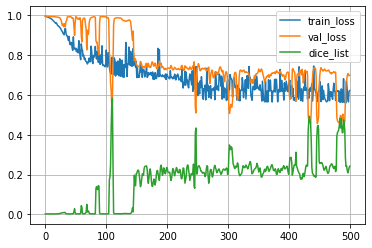

In [25]:
# Plot training loss and validation loss
plt.grid('on')
plt.plot(np.arange(NUM_EPOCH),train_loss_list,label='train_loss')
plt.plot(np.arange(NUM_EPOCH),val_loss_list, label='val_loss')
plt.plot(np.arange(NUM_EPOCH),dice_list, label='dice_list')
plt.legend()

# 6.Test

## Reload the model

In [34]:
checkpoint_path = SAVE_PATH +'MRISegEpoch500.pth'

net = AttU_Net(4,1).to(device)
net.load_state_dict(torch.load(checkpoint_path))
net.eval()

AttU_Net(
  (Maxpool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Maxpool4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(4, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, m

## Reload the data with mask1 and mask2

In [27]:
test_dataset_mask1 = MRIDataset(test_img_list, test_label1_list, test_label2_list, RULE = 'mask1', IF_TRAIN= False)
test_dataset_mask2 = MRIDataset(test_img_list, test_label1_list, test_label2_list, RULE = 'mask2', IF_TRAIN= False)

  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-8-cc23401311c6>:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
<ipython-input-8-cc23401311c6>:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
<ipython-input-8-cc23401311c6>:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predi

In [35]:
test_loader_mask1 = torch.utils.data.DataLoader(test_dataset_mask1, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=0)
test_loader_mask2 = torch.utils.data.DataLoader(test_dataset_mask2, 
                                         batch_size=BATCH_SIZE, 
                                         shuffle=False, 
                                         num_workers=0)

## Test with mask1 and mask2

In [47]:
def eval_epoch_with_threshold(net, data_loader, metric, criterion, threshold):
    # set model in eval mode to avoid updating BN layer
    net = net.eval()
    
    metric_stat = []
    val_loss_stat = []
    for i, img_mask in enumerate(data_loader):
        img, mask = img_mask
        # send data to device
        img = img.to(device)
        mask = mask.to(device)
        # feed data to the model. No need to compute grad.
        with torch.no_grad():
            pred = net(img)
            val_loss = criterion(pred, mask)
            
        # eval the results using DICE function as the metric
        # Convert probability to prediction mask
        pred = pred>threshold
        err = dice_coeff(pred, mask)
        metric_stat += [err.item()]*img.shape[0]
        val_loss_stat += [val_loss.item()]*img.shape[0]
        
    print ("Dice: {:.3f}  Val Loss: {:.3f} Threshod:{:.3f}".format(np.mean(metric_stat), np.mean(val_loss_stat), threshold))
    
    return np.mean(val_loss_stat), np.mean(metric_stat)

In [48]:
for threshold in range(20):
    test_loss, test_dice = eval_epoch_with_threshold(net, test_loader_mask1, dice_coeff, criterion, threshold*0.05)
    test_loss, test_dice = eval_epoch_with_threshold(net, test_loader_mask2, dice_coeff, criterion, threshold*0.05)

Dice: 0.003  Val Loss: 0.551 Threshod:0.000
Dice: 0.003  Val Loss: 0.538 Threshod:0.000
Dice: 0.292  Val Loss: 0.551 Threshod:0.050
Dice: 0.317  Val Loss: 0.538 Threshod:0.050
Dice: 0.334  Val Loss: 0.551 Threshod:0.100
Dice: 0.364  Val Loss: 0.538 Threshod:0.100
Dice: 0.354  Val Loss: 0.551 Threshod:0.150
Dice: 0.385  Val Loss: 0.538 Threshod:0.150
Dice: 0.366  Val Loss: 0.551 Threshod:0.200
Dice: 0.398  Val Loss: 0.538 Threshod:0.200
Dice: 0.376  Val Loss: 0.551 Threshod:0.250
Dice: 0.407  Val Loss: 0.538 Threshod:0.250
Dice: 0.390  Val Loss: 0.551 Threshod:0.300
Dice: 0.421  Val Loss: 0.538 Threshod:0.300
Dice: 0.417  Val Loss: 0.551 Threshod:0.350
Dice: 0.448  Val Loss: 0.538 Threshod:0.350
Dice: 0.738  Val Loss: 0.551 Threshod:0.400
Dice: 0.780  Val Loss: 0.538 Threshod:0.400
Dice: 0.747  Val Loss: 0.551 Threshod:0.450
Dice: 0.782  Val Loss: 0.538 Threshod:0.450
Dice: 0.749  Val Loss: 0.551 Threshod:0.500
Dice: 0.775  Val Loss: 0.538 Threshod:0.500
Dice: 0.749  Val Loss: 0.551 Thr

## Dispaly the output mask

In [49]:
img, mask1 = test_dataset_mask1[0]
img, mask2 = test_dataset_mask2[0]
result = net(img.unsqueeze(0).to(device)).detach()
mask_pred = result.cpu().numpy()[0,0,:,:,:]
mask_pred[mask_pred>0.45] = 1
mask_pred[mask_pred<=0.45] = 0
print(mask_pred.shape)

(181, 217, 181)


Manual Volume for mask1: 5281.0
Manual Volume for mask2: 6429.0
Segmentation Volume: 7304.0


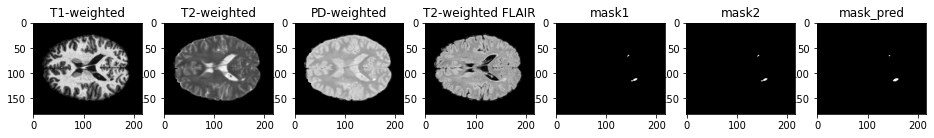

In [50]:
plt.figure(figsize = (16,32))
plt.subplot(1,7,1)
plt.imshow(img[0,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T1-weighted')
plt.subplot(1,7,2)
plt.imshow(img[1,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T2-weighted')
plt.subplot(1,7,3)
plt.imshow(img[2,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('PD-weighted')
plt.subplot(1,7,4)
plt.imshow(img[3,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T2-weighted FLAIR')
plt.subplot(1,7,5)
plt.imshow(mask1.cpu().numpy()[:,:,90],'gray')
plt.title('mask1')
plt.subplot(1,7,6)
plt.imshow(mask1.cpu().numpy()[:,:,90],'gray')
plt.title('mask2')
plt.subplot(1,7,7)
plt.imshow(mask_pred[:,:,90],'gray')
plt.title('mask_pred')

print('Manual Volume for mask1:',mask1.cpu().numpy().sum())
print('Manual Volume for mask2:',mask2.cpu().numpy().sum())
print('Segmentation Volume:',mask_pred.sum())

In [68]:
img, mask1 = test_dataset_mask1[1]
img, mask2 = test_dataset_mask2[1]
result = net(img.unsqueeze(0).to(device)).detach()
mask_pred = result.cpu().numpy()[0,0,:,:,:]
mask_pred[mask_pred>0.45] = 1
mask_pred[mask_pred<=0.45] = 0
print(mask_pred.shape)

(181, 217, 181)


Manual Volume for mask1: 14981.0
Manual Volume for mask2: 17397.0
Segmentation Volume: 12173.0


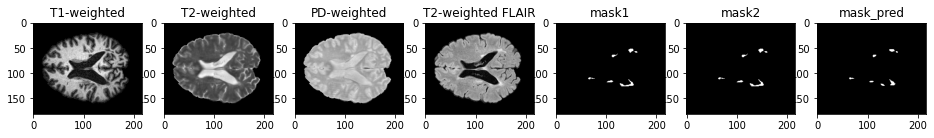

In [69]:
plt.figure(figsize = (16,32))
plt.subplot(1,7,1)
plt.imshow(img[0,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T1-weighted')
plt.subplot(1,7,2)
plt.imshow(img[1,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T2-weighted')
plt.subplot(1,7,3)
plt.imshow(img[2,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('PD-weighted')
plt.subplot(1,7,4)
plt.imshow(img[3,:,:,:].cpu().numpy()[:,:,90],'gray')
plt.title('T2-weighted FLAIR')
plt.subplot(1,7,5)
plt.imshow(mask1.cpu().numpy()[:,:,90],'gray')
plt.title('mask1')
plt.subplot(1,7,6)
plt.imshow(mask1.cpu().numpy()[:,:,90],'gray')
plt.title('mask2')
plt.subplot(1,7,7)
plt.imshow(mask_pred[:,:,90],'gray')
plt.title('mask_pred')

print('Manual Volume for mask1:',mask1.cpu().numpy().sum())
print('Manual Volume for mask2:',mask2.cpu().numpy().sum())
print('Segmentation Volume:',mask_pred.sum())

# Save for evaluation

In [87]:
!wget https://smart-stats-tools.org/sites/default/files/lesion_challenge/testdata_website_2016-03-24.zip /scratch/yl7692

--2021-05-09 04:21:20--  https://smart-stats-tools.org/sites/default/files/lesion_challenge/testdata_website_2016-03-24.zip
Resolving smart-stats-tools.org (smart-stats-tools.org)... 162.129.222.8
Connecting to smart-stats-tools.org (smart-stats-tools.org)|162.129.222.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2257568296 (2.1G) [application/zip]
Saving to: ‘testdata_website_2016-03-24.zip’

testdata_website_20 100%[===================>]   2.10G  36.4MB/s    in 63s     

2021-05-09 04:22:24 (34.3 MB/s) - ‘testdata_website_2016-03-24.zip’ saved [2257568296/2257568296]

/scratch/yl7692: Scheme missing.
FINISHED --2021-05-09 04:22:24--
Total wall clock time: 1m 4s
Downloaded: 1 files, 2.1G in 1m 3s (34.3 MB/s)


## Comparing with original and preprocessed

In [53]:
test_datapath = '/scratch/yl7692/testing/testdata_website'

In [66]:
orig = nib.load(test_datapath + '/test01/orig/test01_01_flair.nii.gz').get_data()
preprocessed = nib.load(test_datapath + '/test01/preprocessed/test01_01_flair_pp.nii').get_data()


<ipython-input-66-ebbfdee25ee9>:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  orig = nib.load(test_datapath + '/test01/orig/test01_01_flair.nii.gz').get_data()
<ipython-input-66-ebbfdee25ee9>:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  preprocessed = nib.load(test_datapath + '/test01/preprocessed/test01_01_flair_pp.nii').get_data()


In [54]:
class MRITestDataset(Dataset):
    def __init__(self, img_path_list, IF_TRAIN= False):
        self.mri_path_list = img_path_list
        self.IF_TRAIN = IF_TRAIN
        #self.transform=transforms.Compose([transforms.Normalize((0.5,),(0.5,))])
        self.mri_list = self.preprocess() 

    def __len__(self):
        return len(self.mri_list)

    def preprocess(self):
        mri_list = []
        for idx in tqdm(range(len(self.mri_path_list))):
            mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
            mri_t2f = (mri_t2f-mri_t2f.min())/(mri_t2f.max()-mri_t2f.min())
            
            mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
            mri_t1w = (mri_t1w-mri_t1w.min())/(mri_t1w.max()-mri_t1w.min())
            
            mri_pd = torch.Tensor(nib.load(self.mri_path_list[idx][2]).get_data())
            mri_pd = (mri_pd-mri_pd.min())/(mri_pd.max()-mri_pd.min())
            
            mri_t2w = torch.Tensor(nib.load(self.mri_path_list[idx][3]).get_data())
            mri_t2w = (mri_t2w-mri_t2w.min())/(mri_t2w.max()-mri_t2w.min())
            
            mri = torch.cat((mri_t1w.unsqueeze(0),mri_t2w.unsqueeze(0),mri_pd.unsqueeze(0),mri_t2f.unsqueeze(0)),axis=0)
        
            
            mri_list.append(mri)

        return mri_list

    def __getitem__ (self,idx):
        img = self.mri_list[idx]
        return img

In [55]:
second_testing_path_list = []
for i in range(1,15):
    if i<10:
        second_testing_path_list.append('test0' + str(i) + '/')
    else:
        second_testing_path_list.append('test' + str(i) + '/')
        
print(second_testing_path_list)
mri_test_list = []

for i in range(14):
    timepoint1_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_01_*.nii')
    timepoint2_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_02_*.nii')
    timepoint3_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_03_*.nii')
    timepoint4_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_04_*.nii')
    if (i==1 or i==9 or i==10 or i==13):
        timepoint5_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_05_*.nii')
    if i==9: 
        timepoint6_path = os.path.join(test_datapath, second_testing_path_list[i], 'preprocessed/*_06_*.nii') 
        print(timepoint6_path)
    
    timepoint1_list = sorted(glob.glob(timepoint1_path))
    timepoint2_list = sorted(glob.glob(timepoint2_path))
    timepoint3_list = sorted(glob.glob(timepoint3_path))
    timepoint4_list = sorted(glob.glob(timepoint4_path))

    
    if (i==1 or i==9 or i==10 or i==13):
        timepoint5_list = sorted(glob.glob(timepoint5_path))
    if i==9:
        timepoint6_list = sorted(glob.glob(timepoint6_path))
    
    mri_test_list.append(timepoint1_list)
    mri_test_list.append(timepoint2_list)
    mri_test_list.append(timepoint3_list)
    mri_test_list.append(timepoint4_list)

    if (i==1 or i==9 or i==10 or i==13):
        mri_test_list.append(timepoint5_list)

    if i==9:
        mri_test_list.append(timepoint6_list)
        

print('Data Collected:', len(mri_test_list))


['test01/', 'test02/', 'test03/', 'test04/', 'test05/', 'test06/', 'test07/', 'test08/', 'test09/', 'test10/', 'test11/', 'test12/', 'test13/', 'test14/']
/scratch/yl7692/testing/testdata_website/test10/preprocessed/*_06_*.nii
Data Collected: 61


In [56]:
test_dataset = MRITestDataset(mri_test_list, IF_TRAIN= True)

  0%|          | 0/61 [00:00<?, ?it/s]<ipython-input-54-cca191b18e00>:14: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t2f = torch.Tensor(nib.load(self.mri_path_list[idx][0]).get_data())
<ipython-input-54-cca191b18e00>:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  mri_t1w = torch.Tensor(nib.load(self.mri_path_list[idx][1]).get_data())
<ipython-input-54-cca191b18e00>:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more p

In [57]:
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                         batch_size=1, 
                                         shuffle=False, 
                                         num_workers=0)

In [75]:
def pre_and_save(net, dataloader):
    net = net.eval()
    num_list = [4,5,4,4,4,4,4,4,4,6,5,4,4,5]
    cnt_num = 0;
    cnt = 0;
    for i, test_input in enumerate(dataloader):
        test_input = test_input.to(device)
        with torch.no_grad():
            pred = net(test_input[0].unsqueeze(0).to(device)).detach()
            pred[pred>0.45] = 1
            pred[pred<=0.45] = 0
            pred = pred.cpu().numpy().squeeze()
            new_image = nib.Nifti1Image(pred, np.eye(4)) 
            
        if (cnt == num_list[cnt_num]):
            cnt_num += 1
            cnt = 0;
        if i < 37:
            nib.save(new_image, '/scratch/yl7692/self-attention_Unet_OR_test_result/' + 'test0' + str(cnt_num+1) + '_0' + str(cnt+1)+ '_NYU.nii')
        else:
            nib.save(new_image, '/scratch/yl7692/self-attention_Unet_OR_test_result/' + 'test' + str(cnt_num+1) + '_0' + str(cnt+1)+ '_NYU.nii')
        cnt = cnt+1

In [76]:
num_list = [4,5,4,4,4,4,4,4,4,6,5,4,4,5]
print(sum(num_list))

61


In [77]:
pre_and_save(net, test_loader)

(181, 217, 181)


<ipython-input-90-4e75e9eedb19>:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  testimg = nib.load('/scratch/yl7692/self-attention_Unet_OR_test_result/test12_02_NYU.nii').get_data()


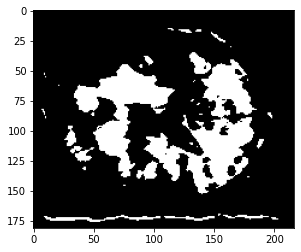

In [90]:
testimg = nib.load('/scratch/yl7692/self-attention_Unet_OR_test_result/test12_02_NYU.nii').get_data()
print(testimg.shape)
plt.imshow(testimg[:,:,90], cmap='gray')